In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('..')
import os
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from numba import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import src.problemgenerator.utils as utils
from src import runner_
from src.datasets.utils import load_newsgroups
from src.ml.utils import reduce_dimensions_sparse
from src.plotting.utils import visualize_scores, visualize_classes, print_results, visualize_confusion_matrices
from src.problemgenerator.array import Array
from src.problemgenerator.filters import OCRError

warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

In [3]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, train_data, test_data):
        vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
        vectorized_train_data = vectorizer.fit_transform(train_data)
        vectorized_test_data = vectorizer.transform(test_data)

        reduced_test_data = reduce_dimensions_sparse(vectorized_test_data, self.random_state)

        return vectorized_train_data, vectorized_test_data, {"reduced_test_data": reduced_test_data}


class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        predicted_test_labels = fitted_model.predict(test_data)
        cm = confusion_matrix(test_labels, predicted_test_labels)

        return {
            "confusion_matrix": cm,
            "predicted_test_labels": predicted_test_labels,
            "test_mean_accuracy": round(np.mean(predicted_test_labels == test_labels), 3),
            "train_mean_accuracy": fitted_model.score(train_data, train_labels),
        }


class MultinomialNBModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return MultinomialNB(params["alpha"]).fit(train_data, train_labels)


class LinearSVCModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return LinearSVC(C=params["C"], random_state=self.random_state).fit(train_data, train_labels)



In [4]:
def visualize(df, dataset_name, label_names, test_data):
    visualize_scores(df, ["test_mean_accuracy", "train_mean_accuracy"], "p",
                     f"{dataset_name} classification scores with added error")
    visualize_classes(df, label_names, "p", "reduced_test_data", "test_labels", "tab20",
                      f"{dataset_name} (n={len(test_data)}) classes with added error")

    def on_click(element, label, predicted_label):
        print(label, " predicted as ", predicted_label, ":", sep="")
        print(element, end="\n\n")

    # Remember to enable runner's interactive mode
    visualize_confusion_matrices(df, label_names, "test_mean_accuracy", "p",
                                 "test_labels", "predicted_test_labels", on_click)

    plt.show()

In [5]:
def main(argv):
    if len(argv) == 3 and argv[1] in ["all", "test"]:
        data, labels, label_names, dataset_name = load_newsgroups(argv[1], int(argv[2]))
    else:
        exit(0)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2,
                                                                        random_state=RandomState(42))
    
    curr_dir = os.getcwd()
    os.chdir("..") # Move up one directory since config and notebooks directories are on the same level
    params = utils.load_ocr_error_params("config/example_text_error_params.json")
    os.chdir(curr_dir) # Move down back to where we started
    
    normalized_params = utils.normalize_ocr_error_params(params)
    p_steps = np.linspace(0, 1, num=11)
    err_params_list = [{
        "p": p,
        "normalized_params": normalized_params
    } for p in p_steps]

    alpha_steps = [10 ** i for i in range(-2, 1)]
    C_steps = [10 ** k for k in range(-2, 1)]
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    model_params_dict_list = [
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": False
        },
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": True
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": False
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": True
        },
    ]

    err_root_node = Array()
    err_root_node.addfilter(OCRError("normalized_params", "p"))

    df = runner_.run(train_data, test_data, Preprocessor, err_root_node, err_params_list, model_params_dict_list,
                     use_interactive_mode=True)

    print_results(df, ["train_labels", "test_labels", "reduced_test_data", "confusion_matrix", "predicted_test_labels",
                       "radius_generator", "missing_value", "normalized_params"])

    visualize(df, dataset_name, label_names, test_data)


100%|██████████| 11/11 [04:41<00:00, 29.17s/it]

LinearSVC
       C    p  test_mean_accuracy  time_used_err  time_used_mod  time_used_preproc  train_mean_accuracy
0   0.01  0.0               0.789       5.441873       0.218767          15.196635             0.897900
1   0.10  0.0               0.823       5.441873       0.123561          15.196635             0.955412
2   1.00  0.0               0.820       5.441873       0.231587          15.196635             0.969305
3   0.01  0.1               0.739      21.248094       0.108588          16.202303             0.905331
4   0.10  0.1               0.793      21.248094       0.148343          16.202303             0.957997
5   1.00  0.1               0.792      21.248094       0.273113          16.202303             0.970921
6   0.01  0.2               0.689      33.482569       0.123656          16.092243             0.907916
7   0.10  0.2               0.753      33.482569       0.170840          16.092243             0.957997
8   1.00  0.2               0.760      33.482569      

<IPython.core.display.Javascript object>


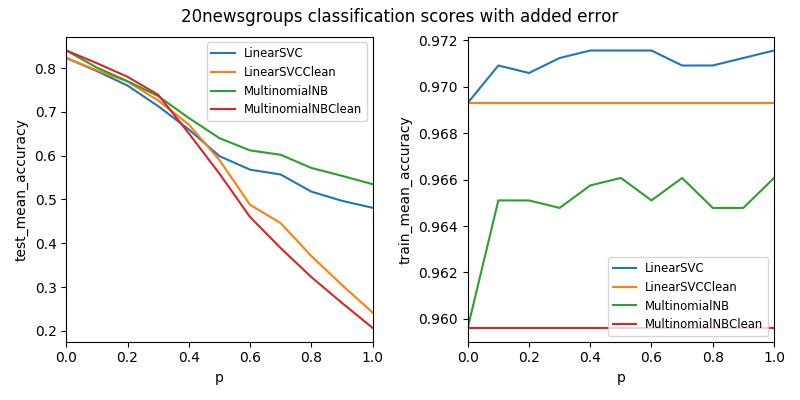

<IPython.core.display.Javascript object>


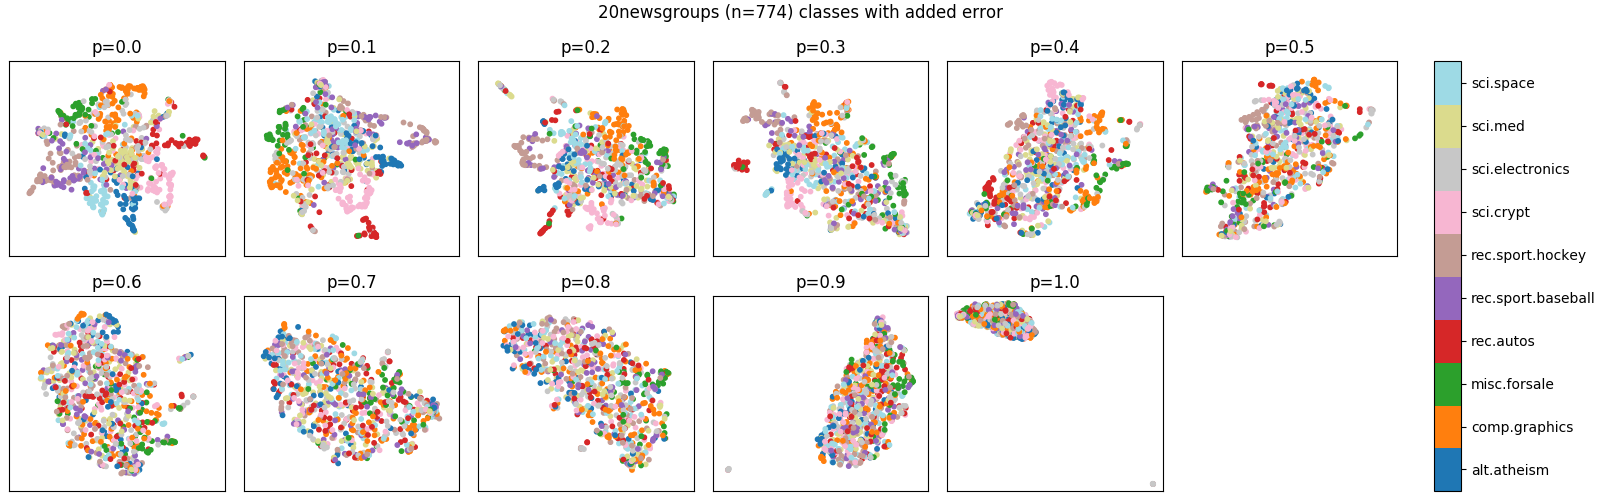

<IPython.core.display.Javascript object>


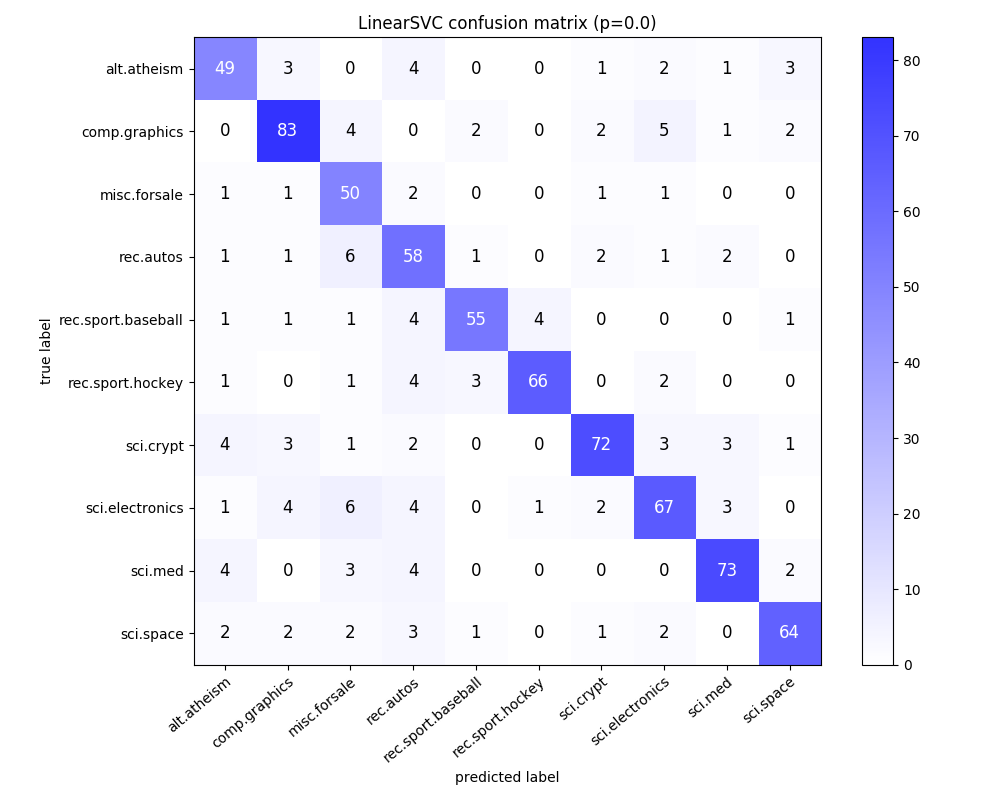

<IPython.core.display.Javascript object>


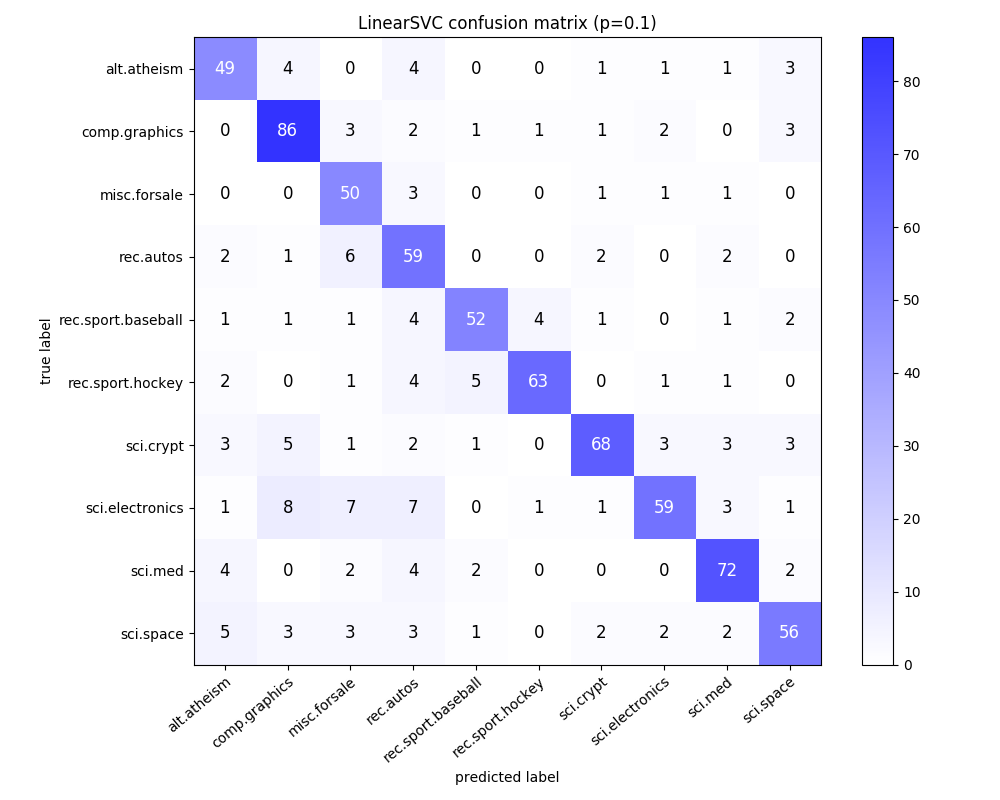

<IPython.core.display.Javascript object>


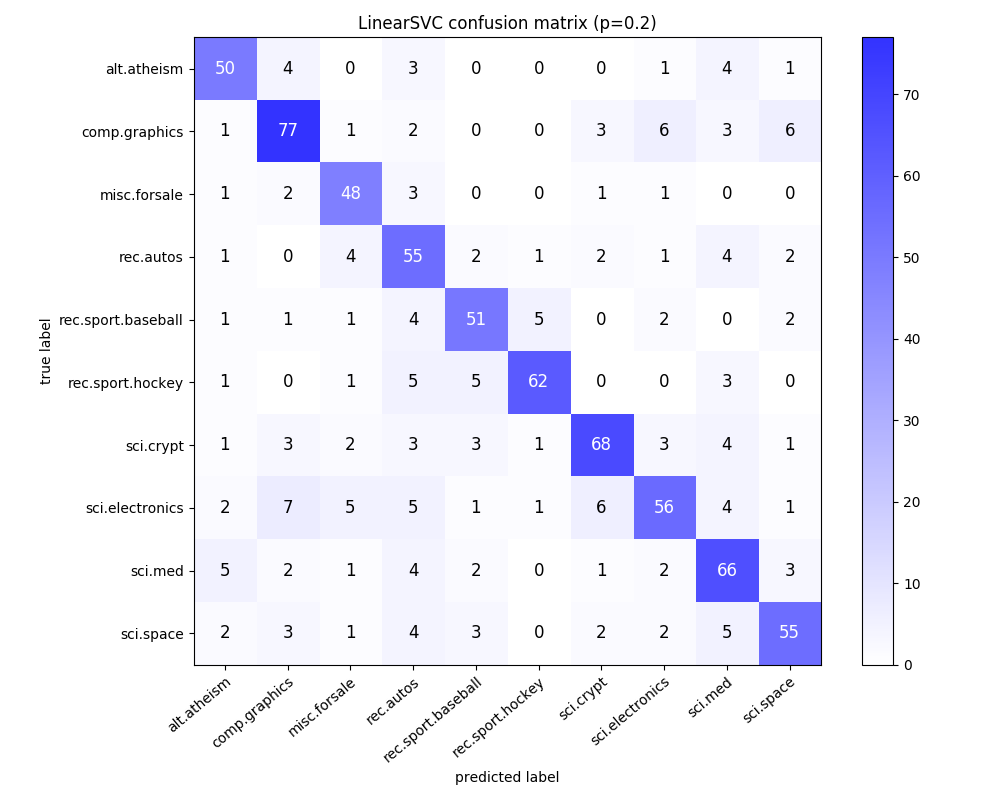

<IPython.core.display.Javascript object>


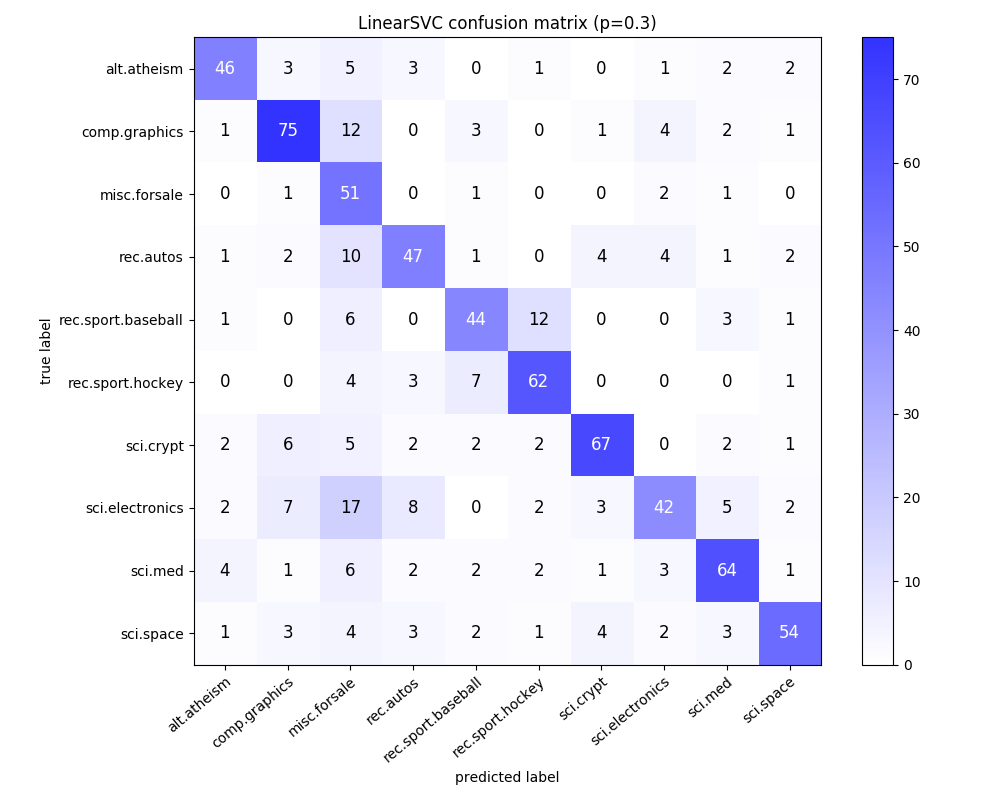

<IPython.core.display.Javascript object>


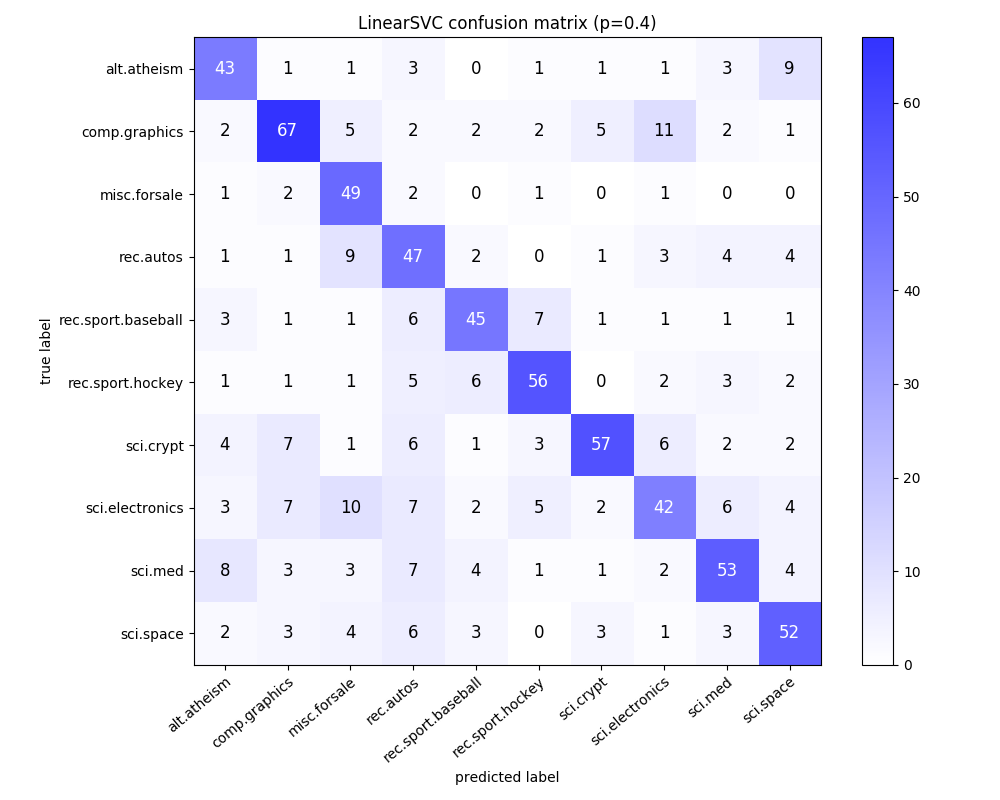

<IPython.core.display.Javascript object>


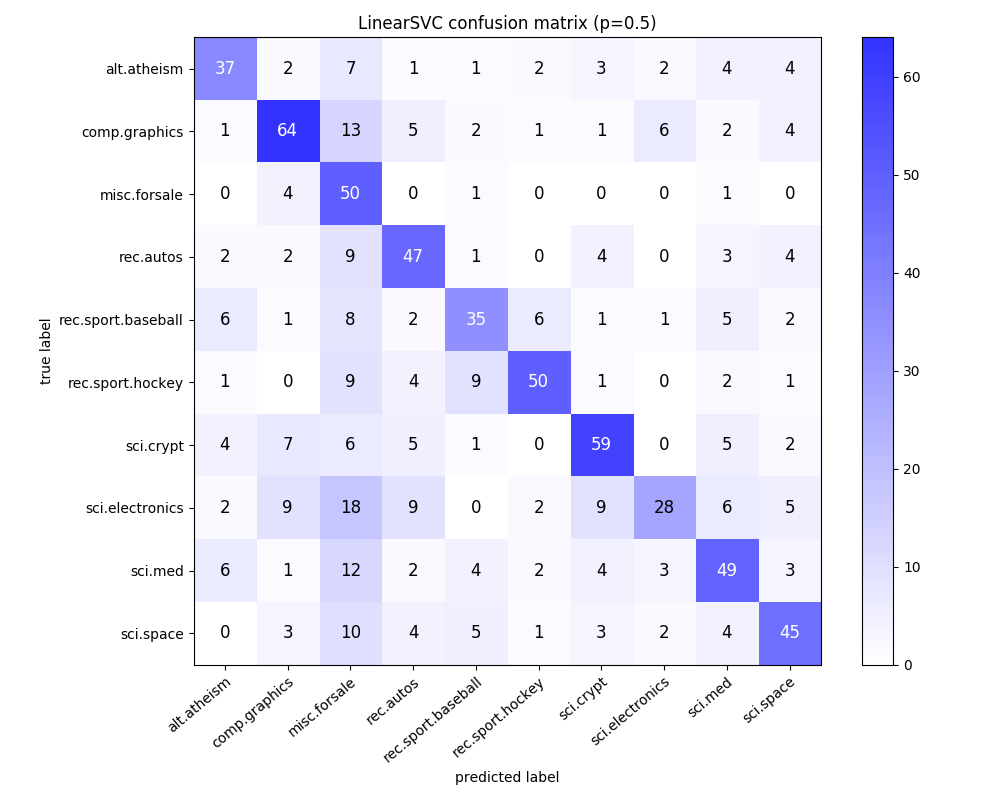

<IPython.core.display.Javascript object>


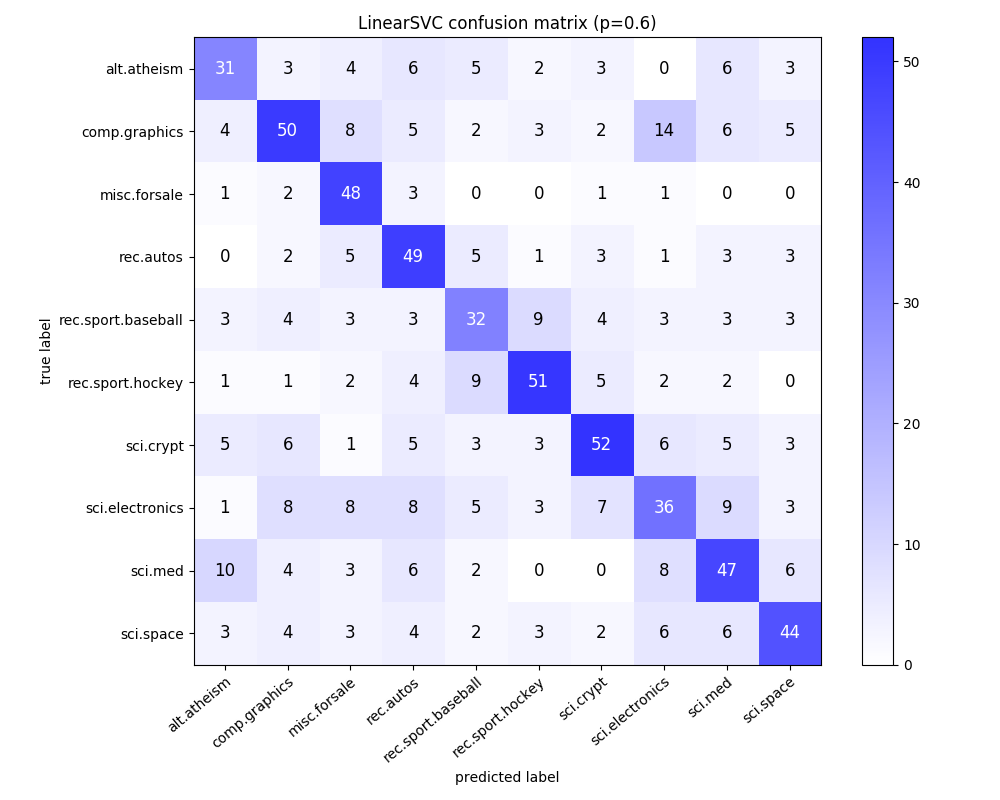

<IPython.core.display.Javascript object>


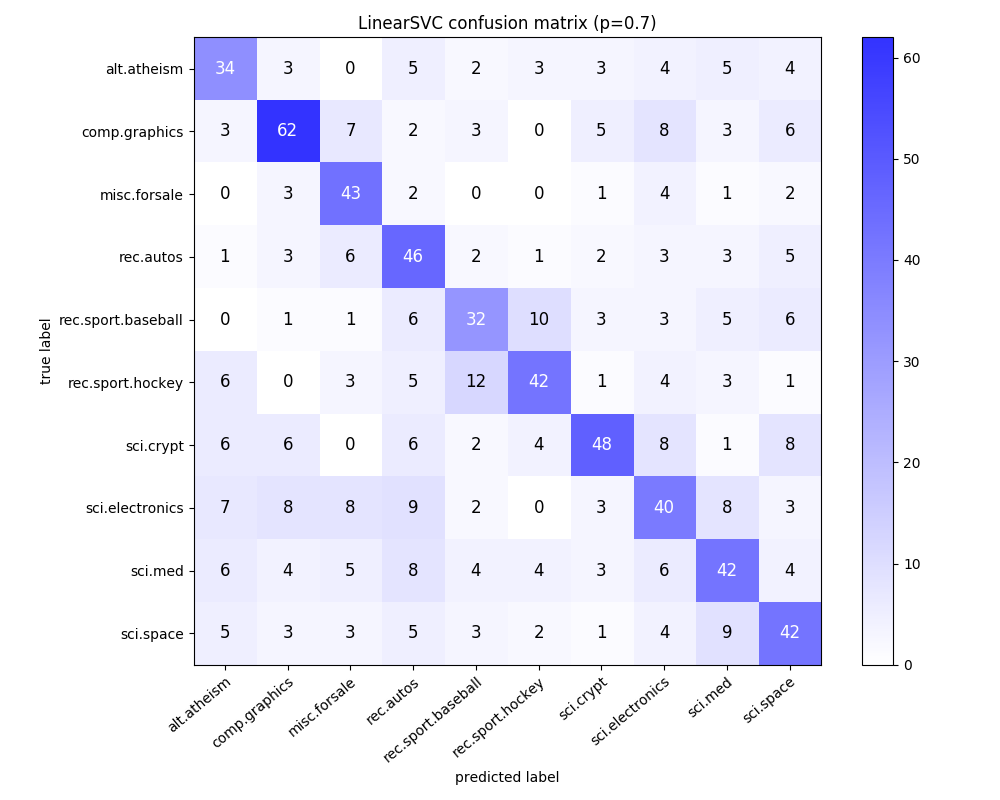

<IPython.core.display.Javascript object>


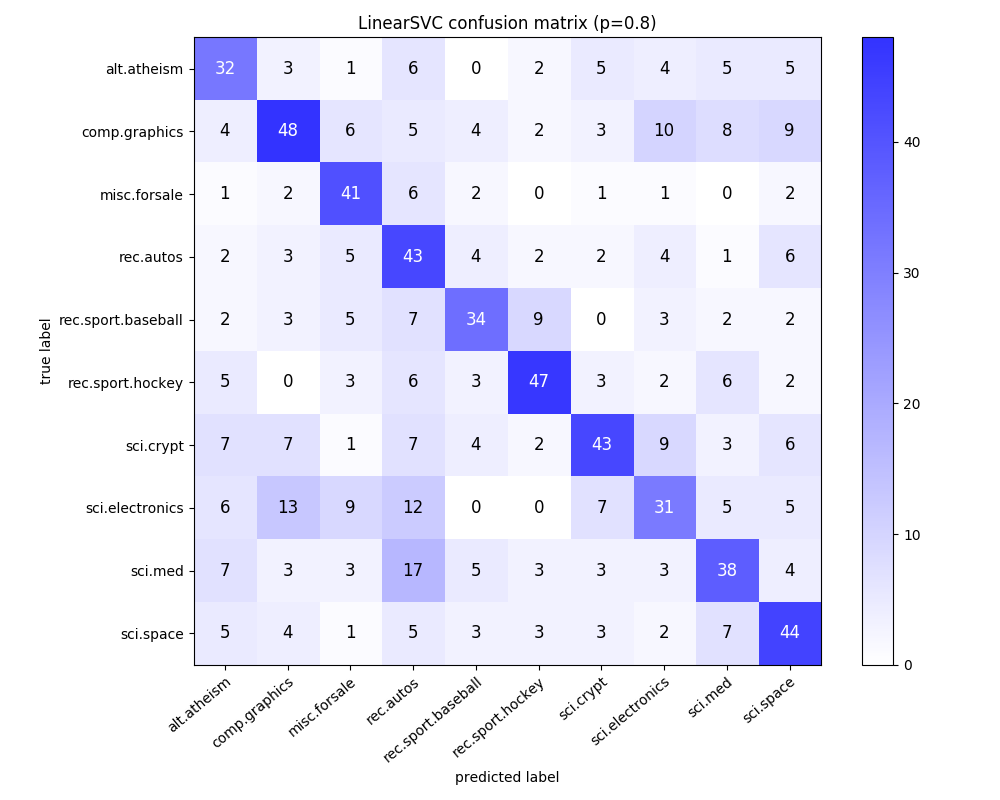

<IPython.core.display.Javascript object>


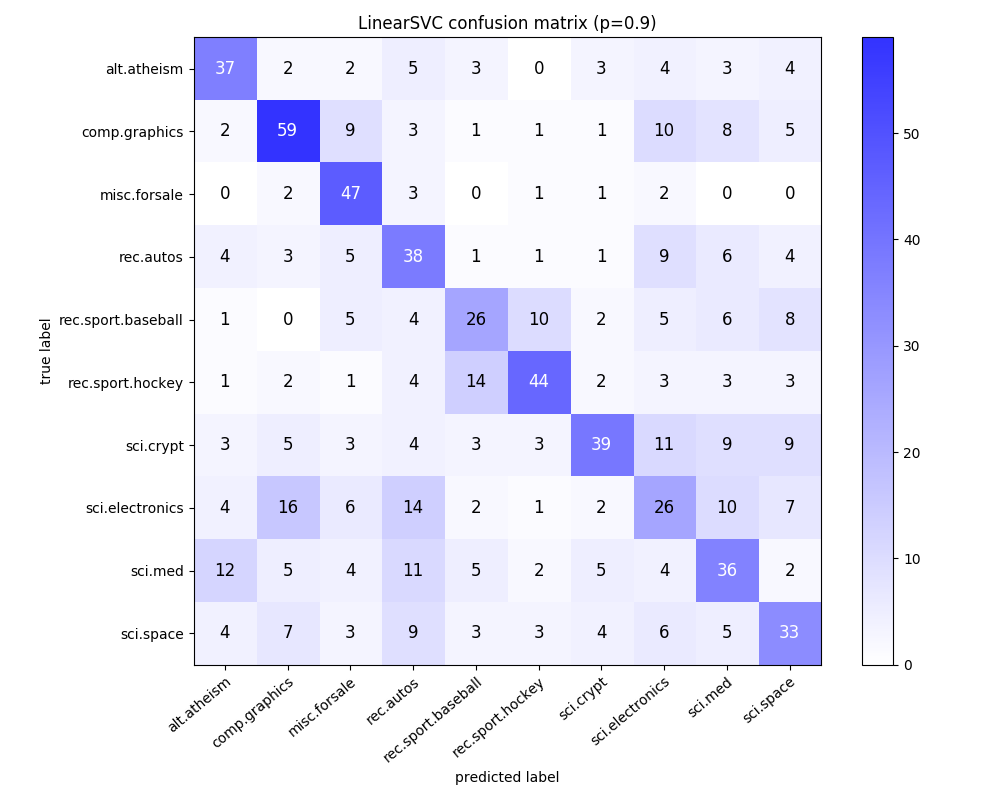

<IPython.core.display.Javascript object>


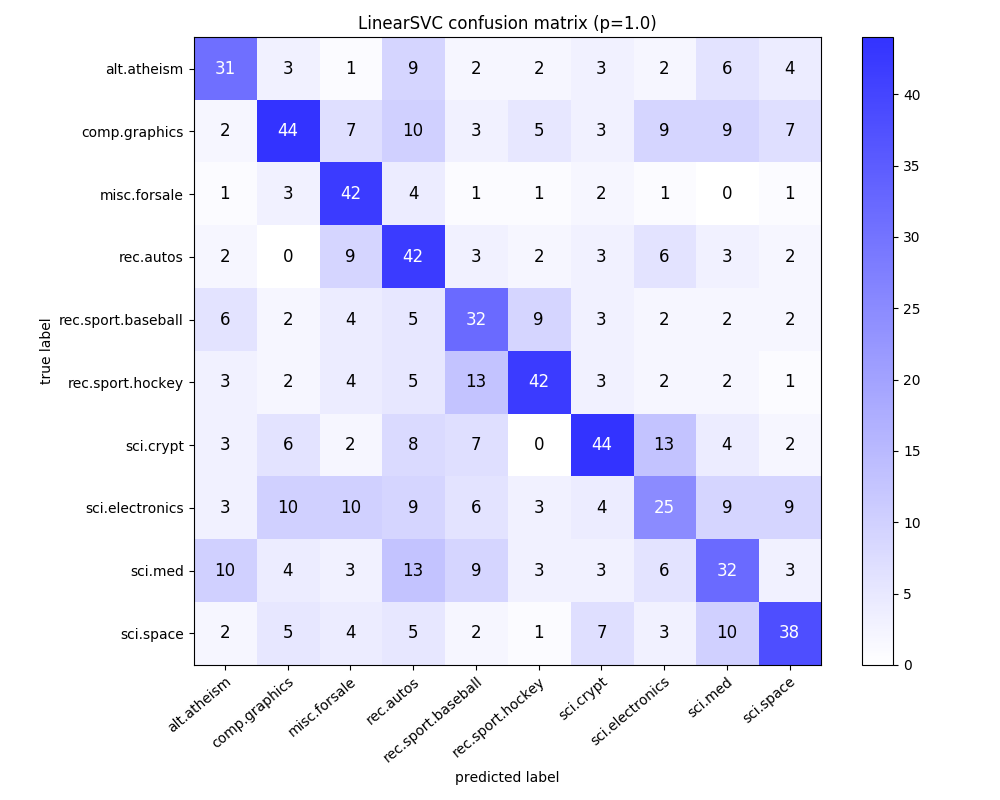

<IPython.core.display.Javascript object>


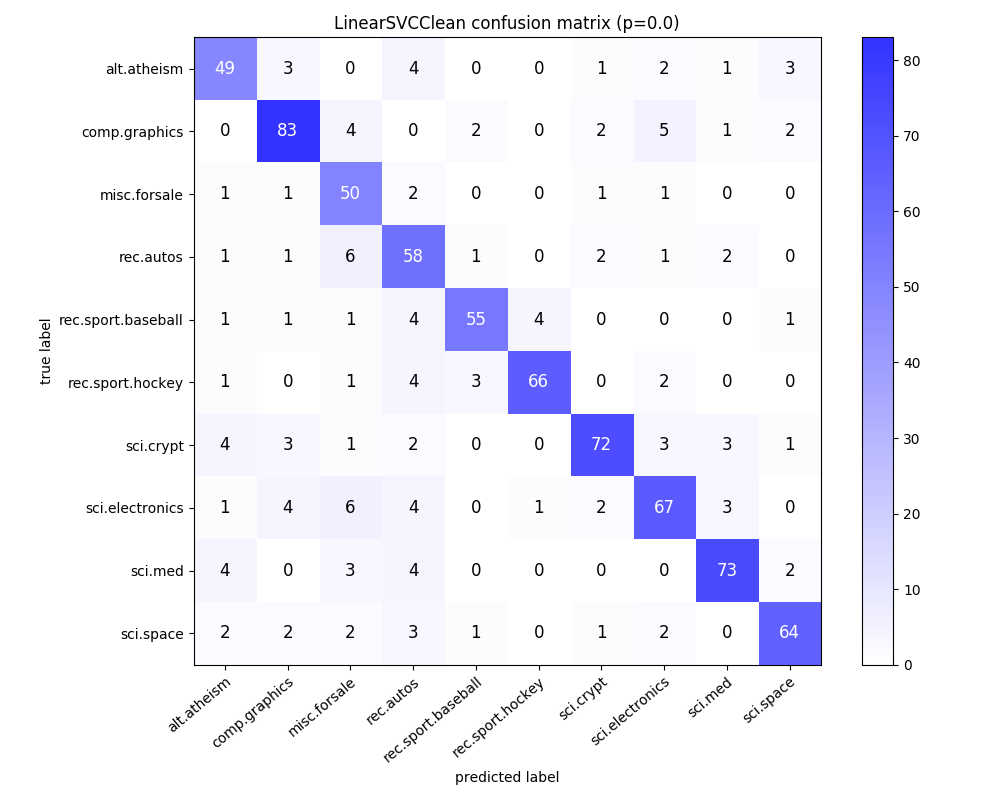

<IPython.core.display.Javascript object>


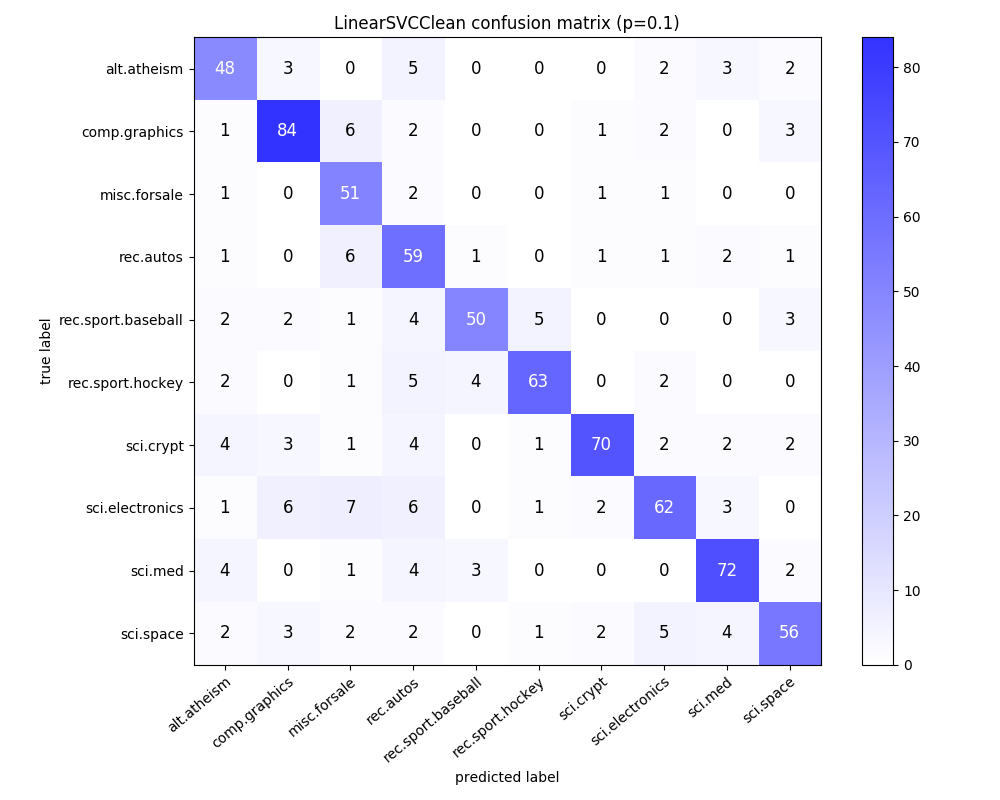

<IPython.core.display.Javascript object>


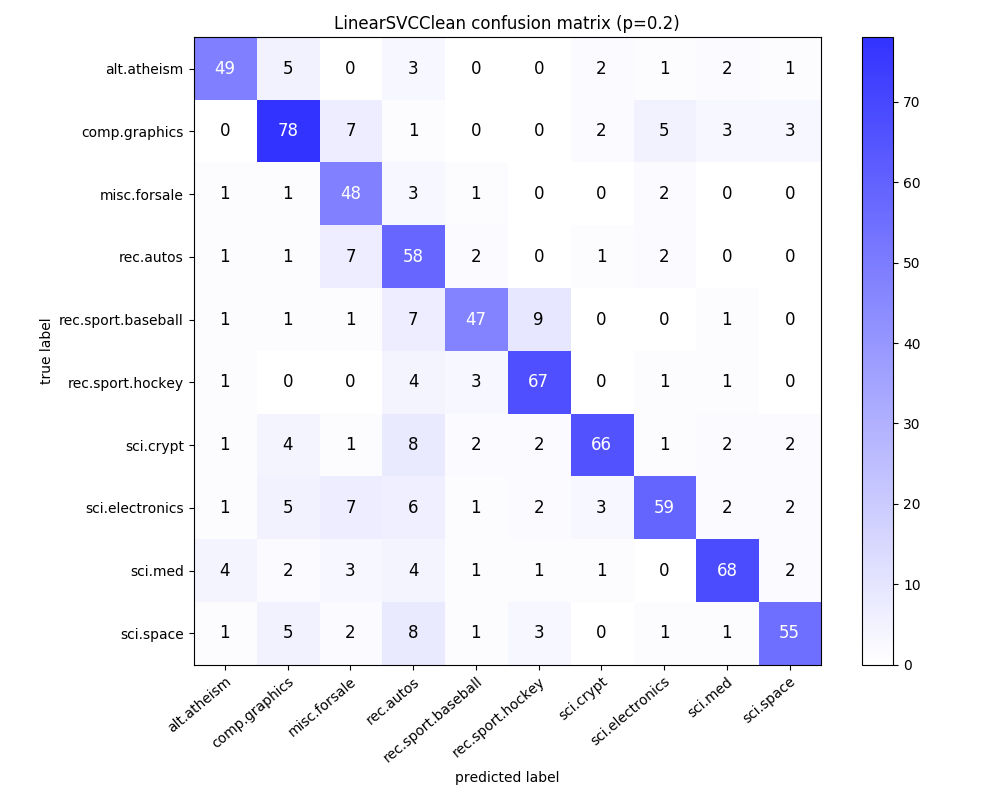

<IPython.core.display.Javascript object>


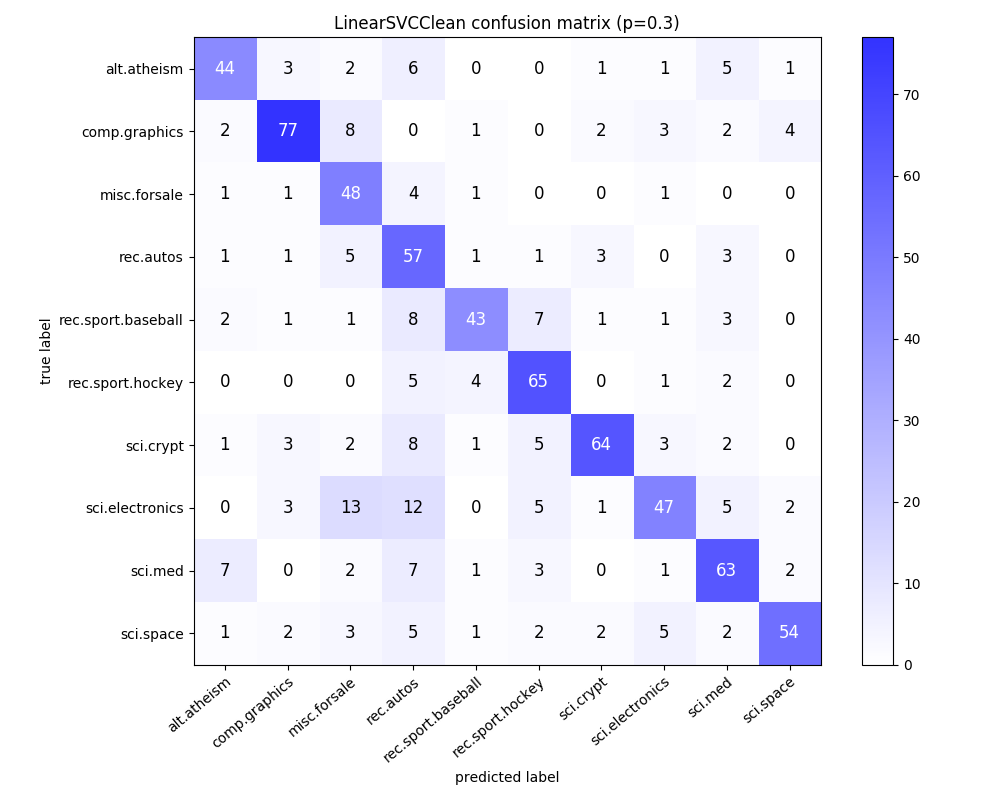

<IPython.core.display.Javascript object>


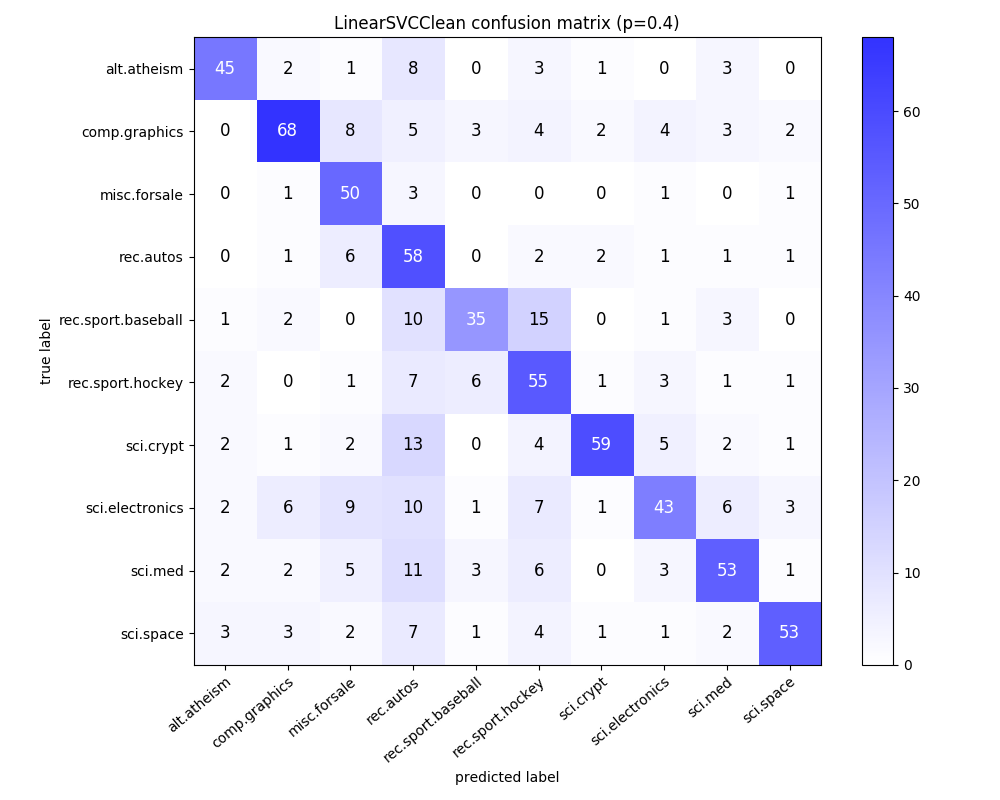

<IPython.core.display.Javascript object>


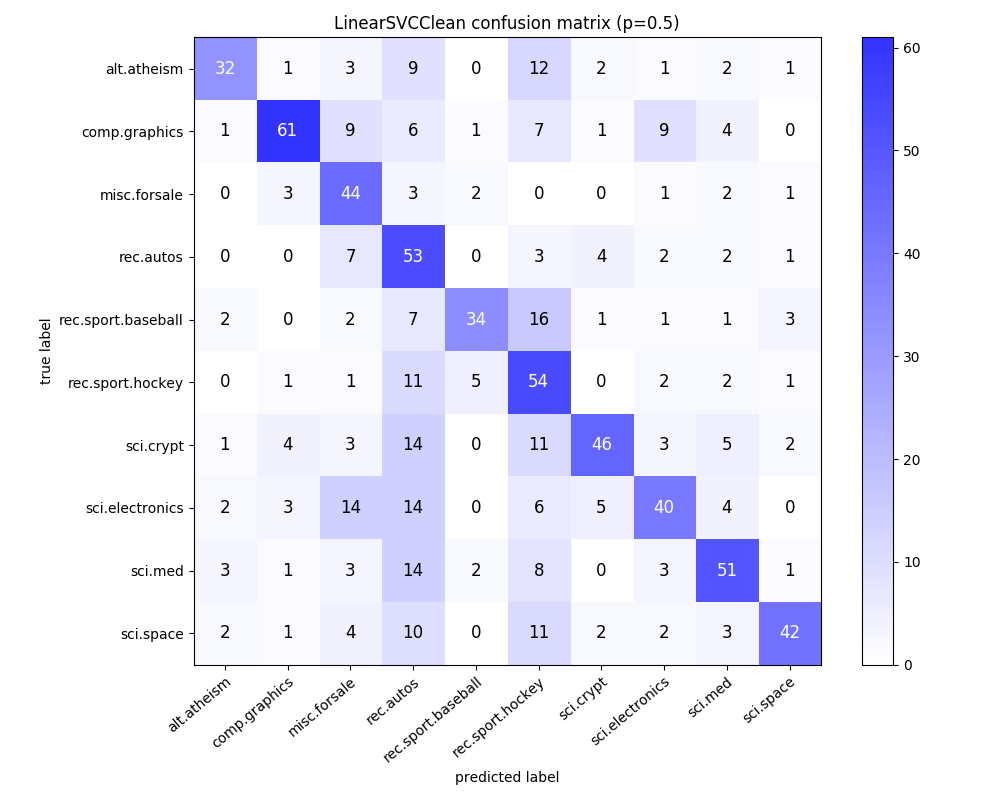

<IPython.core.display.Javascript object>


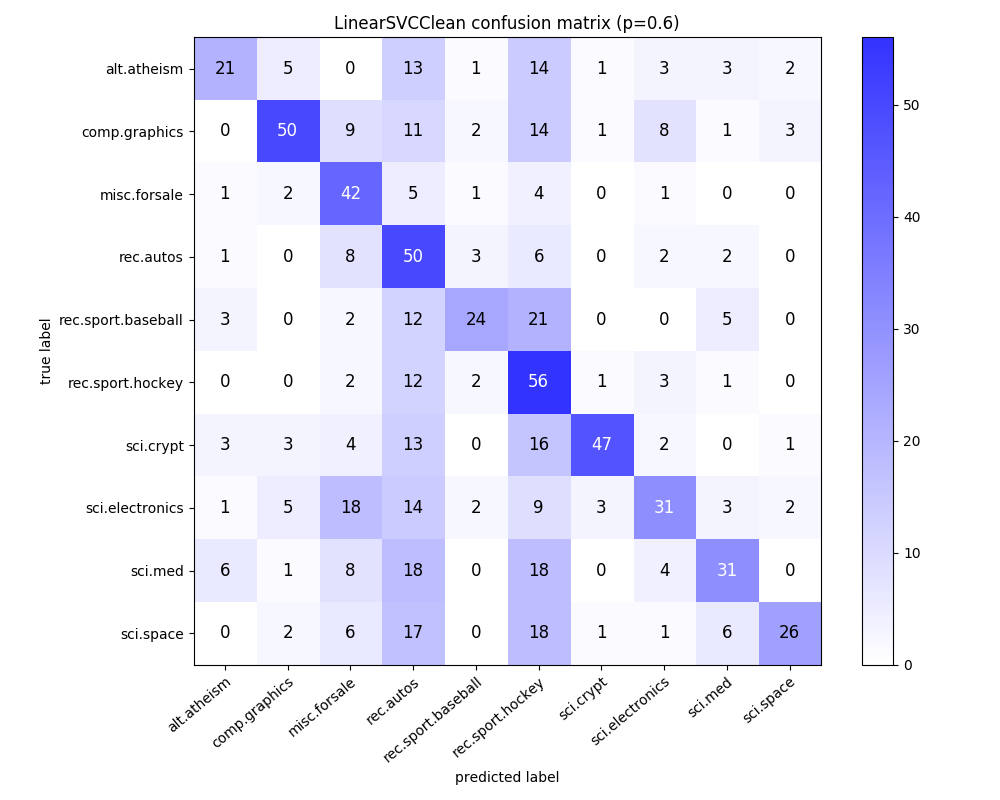

../src/plotting/utils.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 8))


<IPython.core.display.Javascript object>


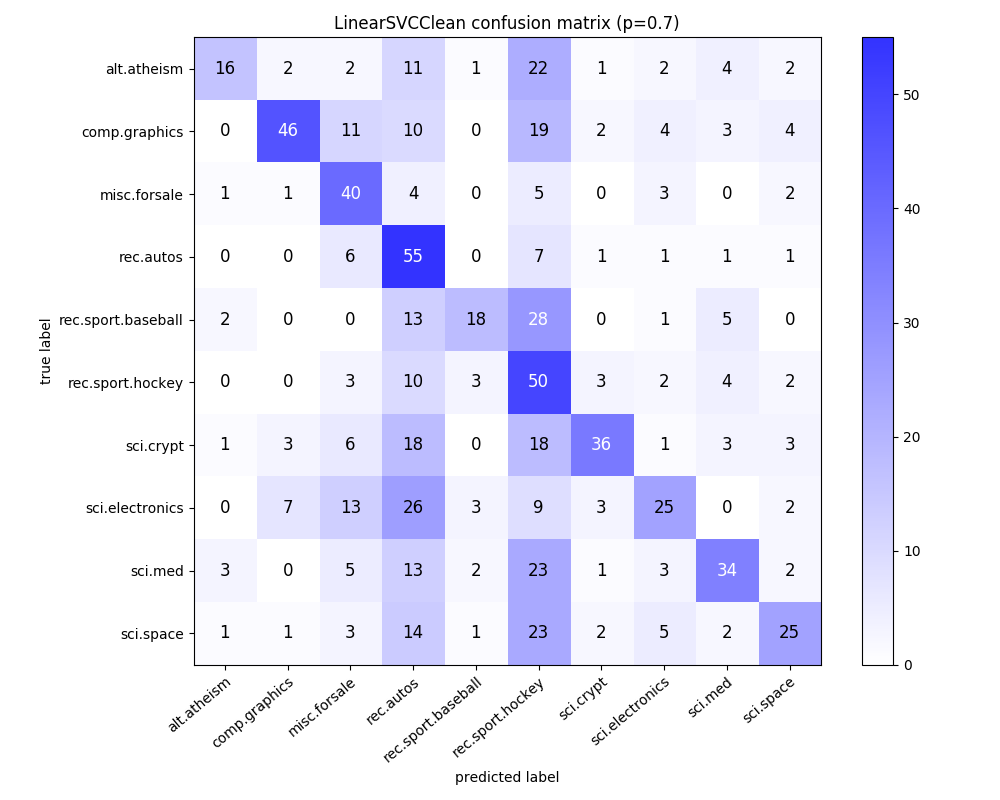

<IPython.core.display.Javascript object>


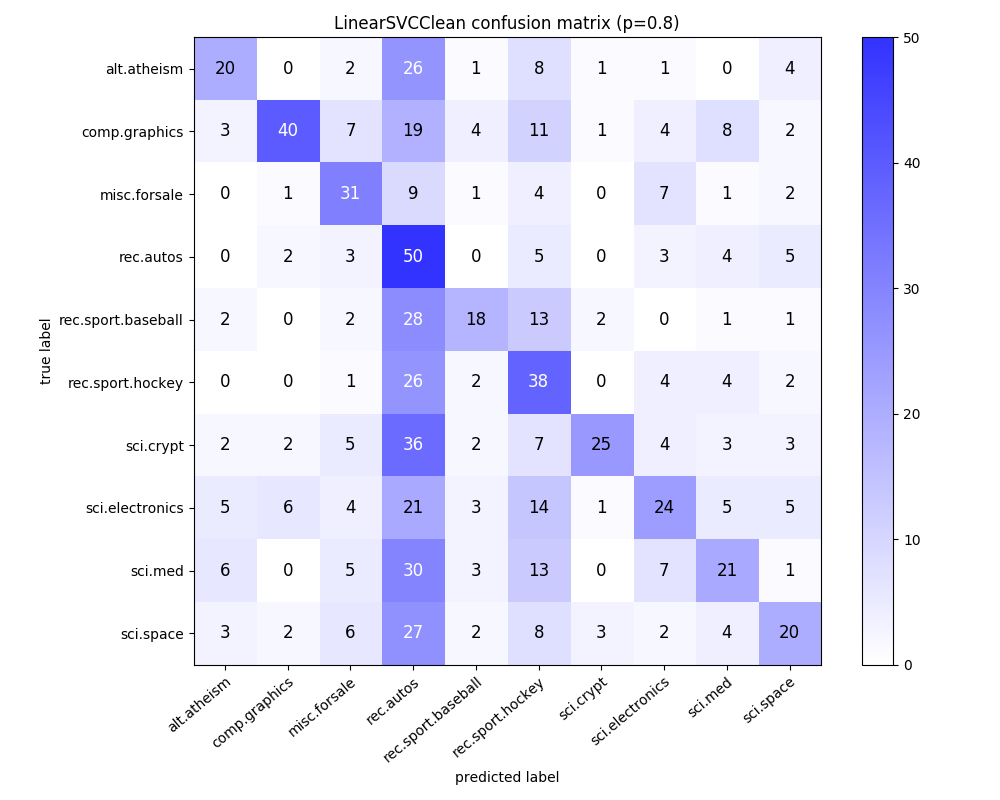

<IPython.core.display.Javascript object>


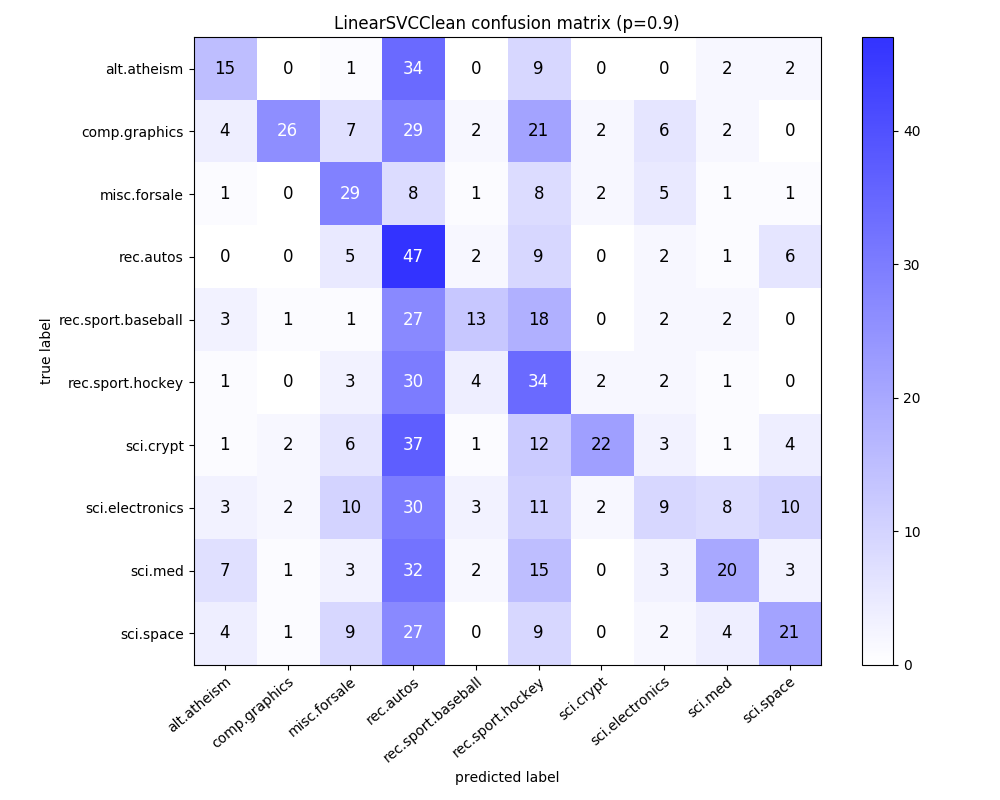

<IPython.core.display.Javascript object>


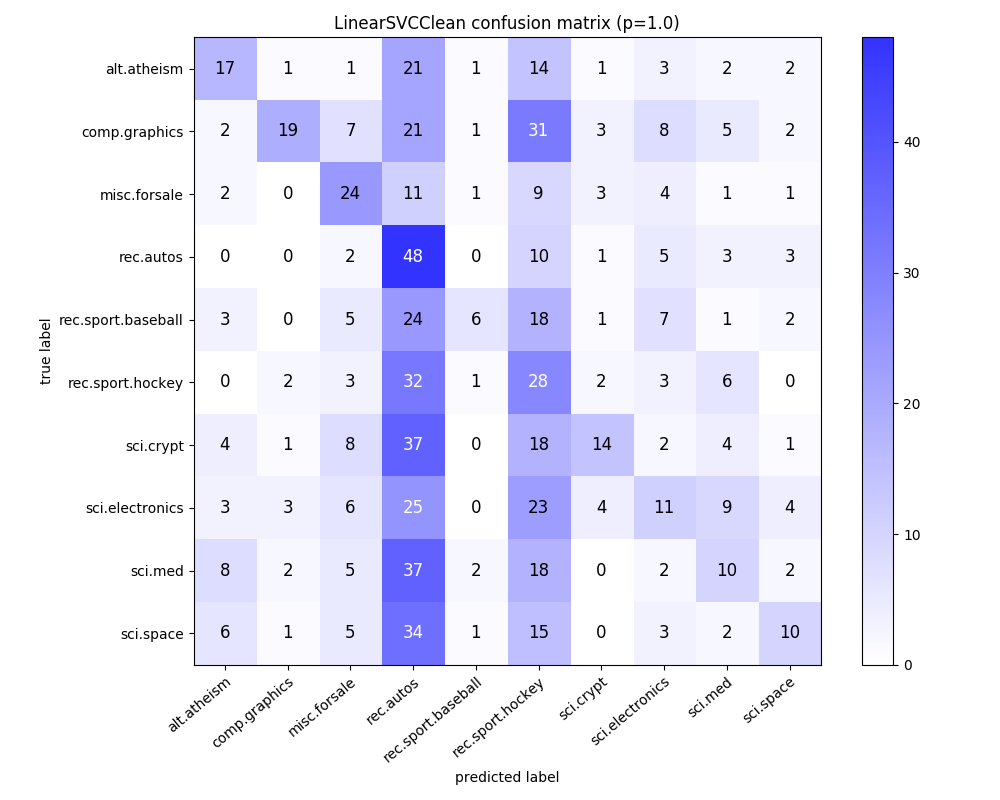

<IPython.core.display.Javascript object>


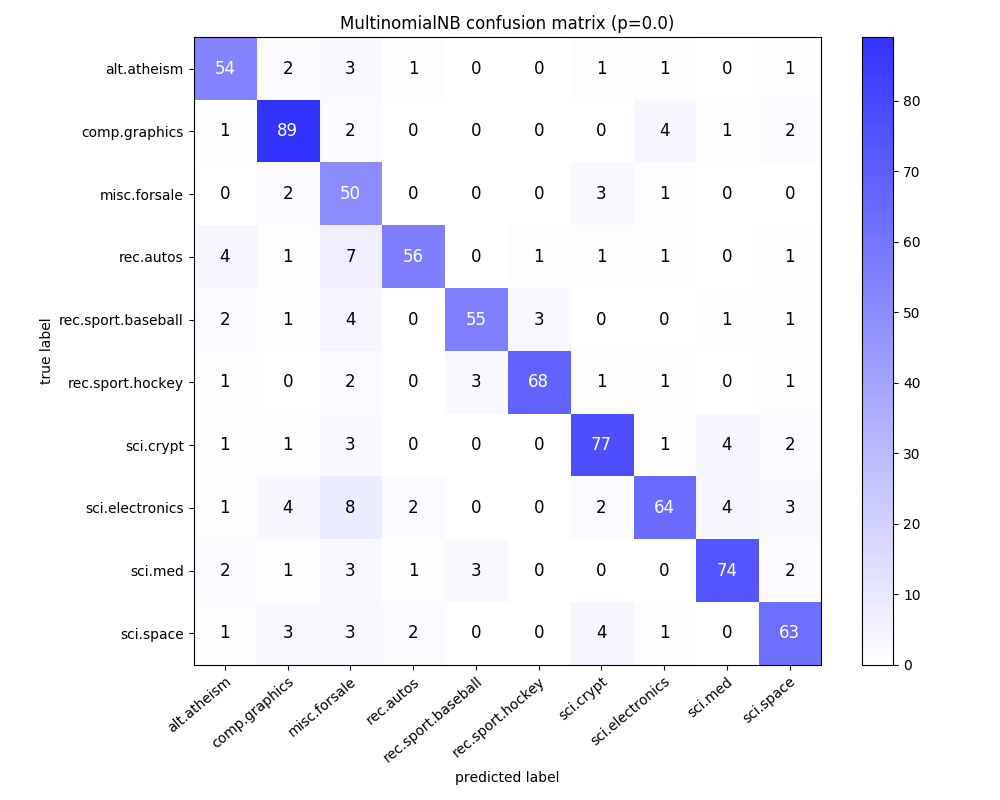

<IPython.core.display.Javascript object>


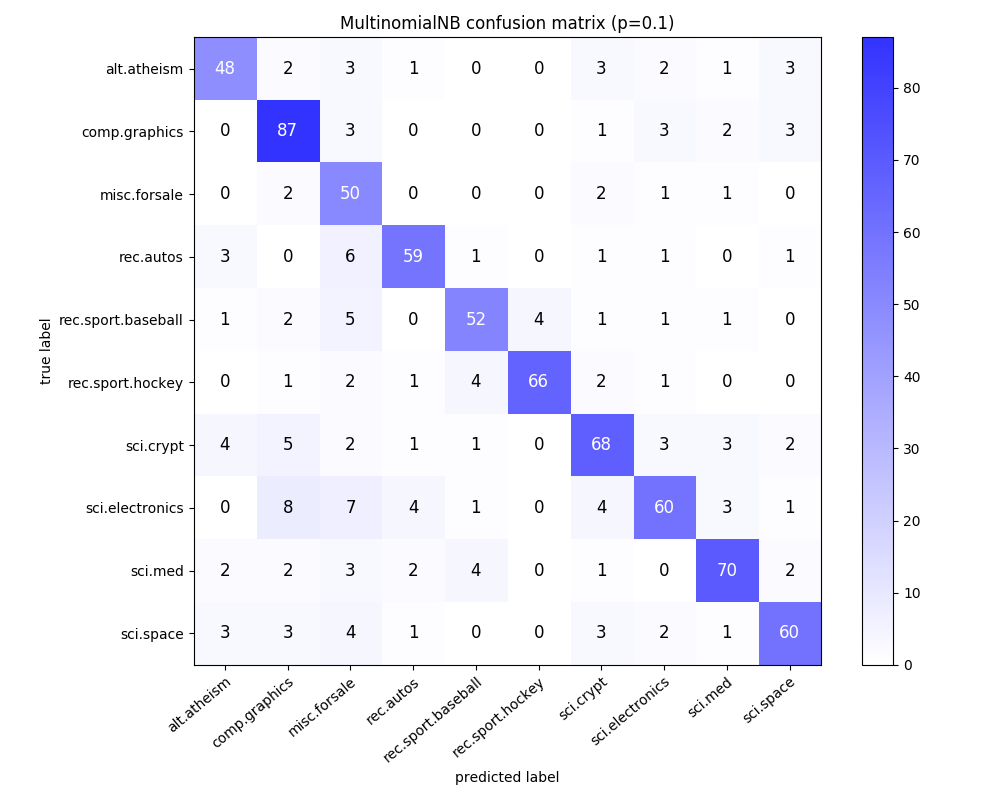

<IPython.core.display.Javascript object>


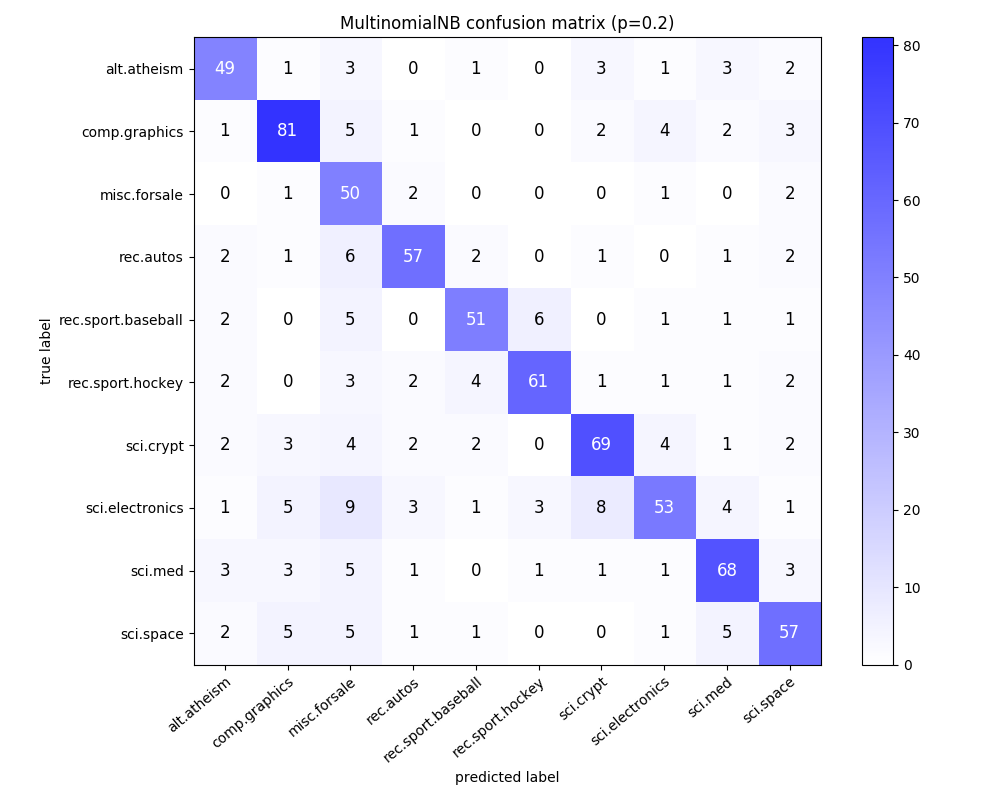

<IPython.core.display.Javascript object>


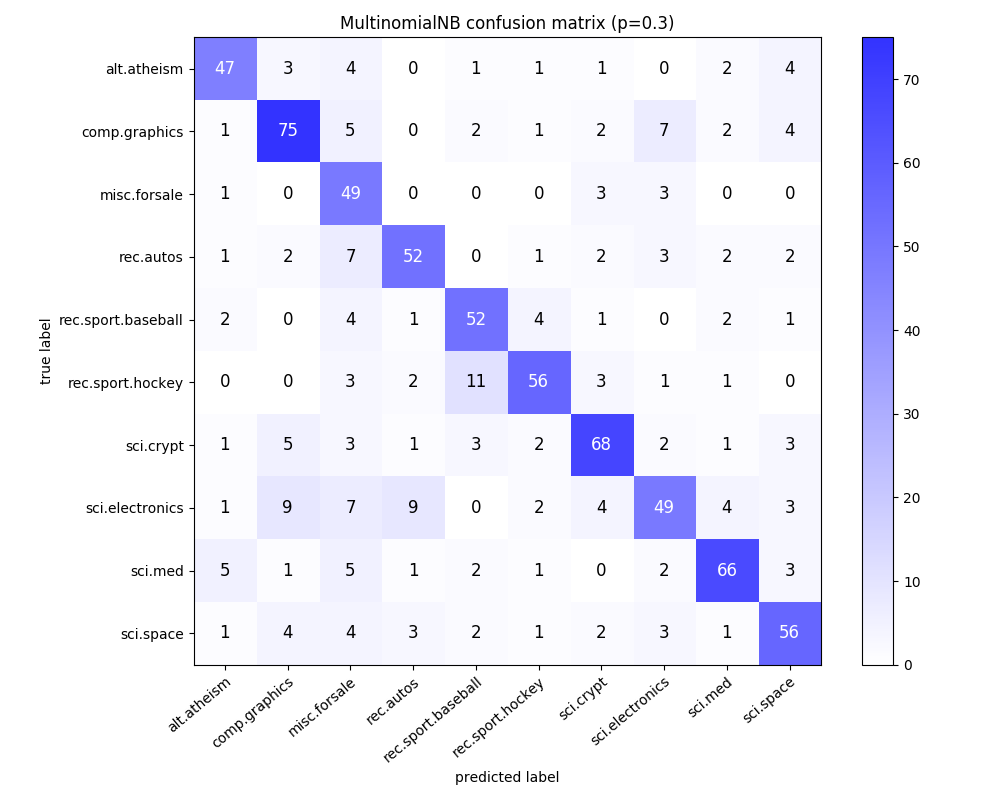

<IPython.core.display.Javascript object>


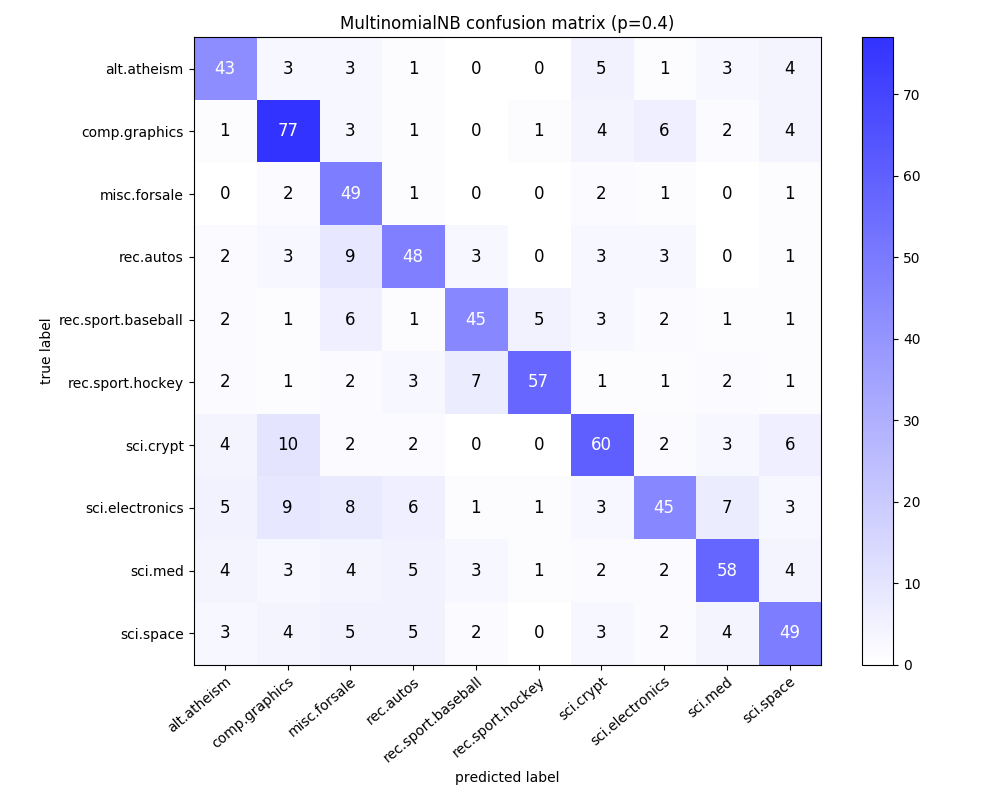

<IPython.core.display.Javascript object>


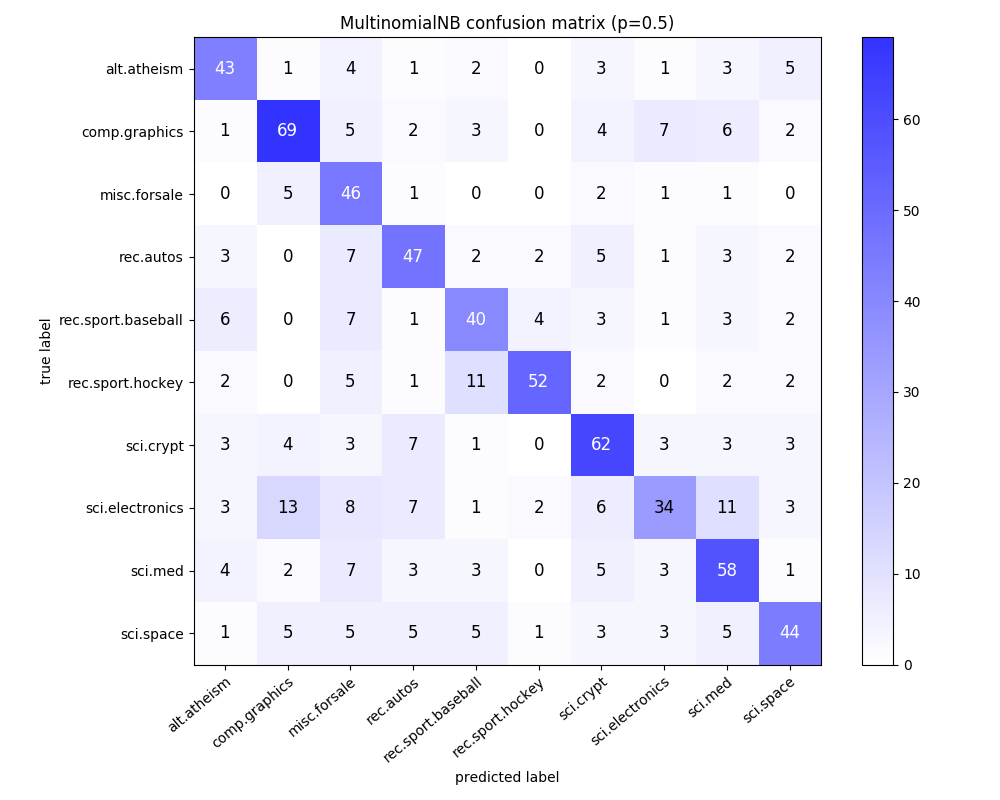

<IPython.core.display.Javascript object>


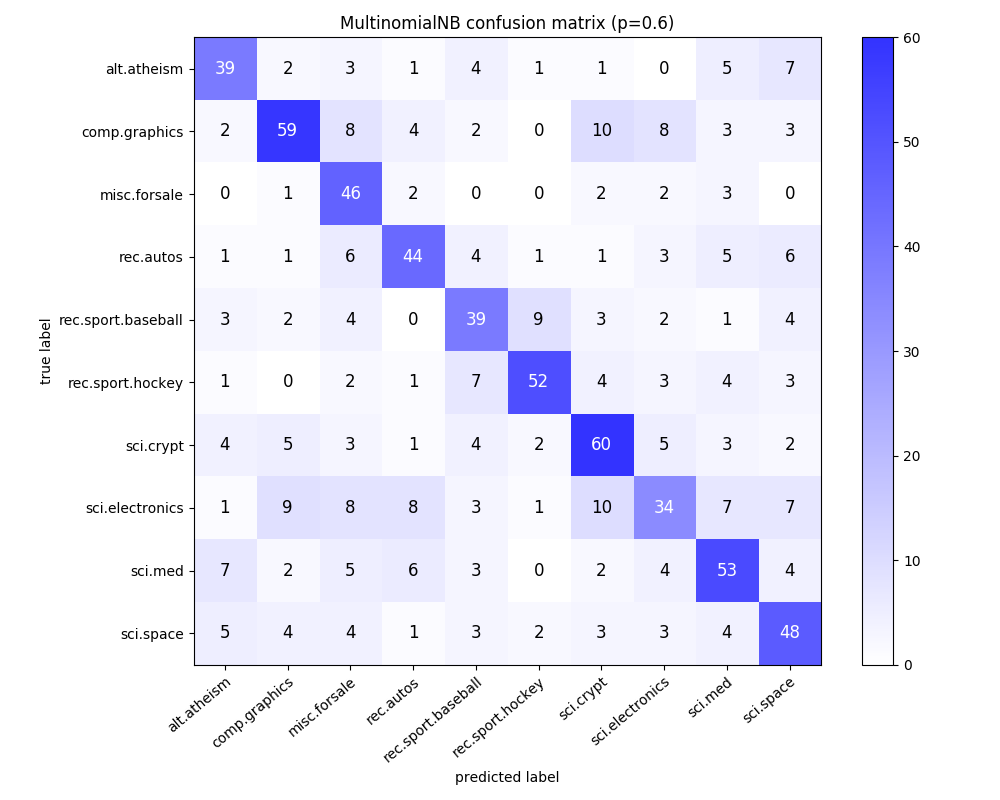

<IPython.core.display.Javascript object>


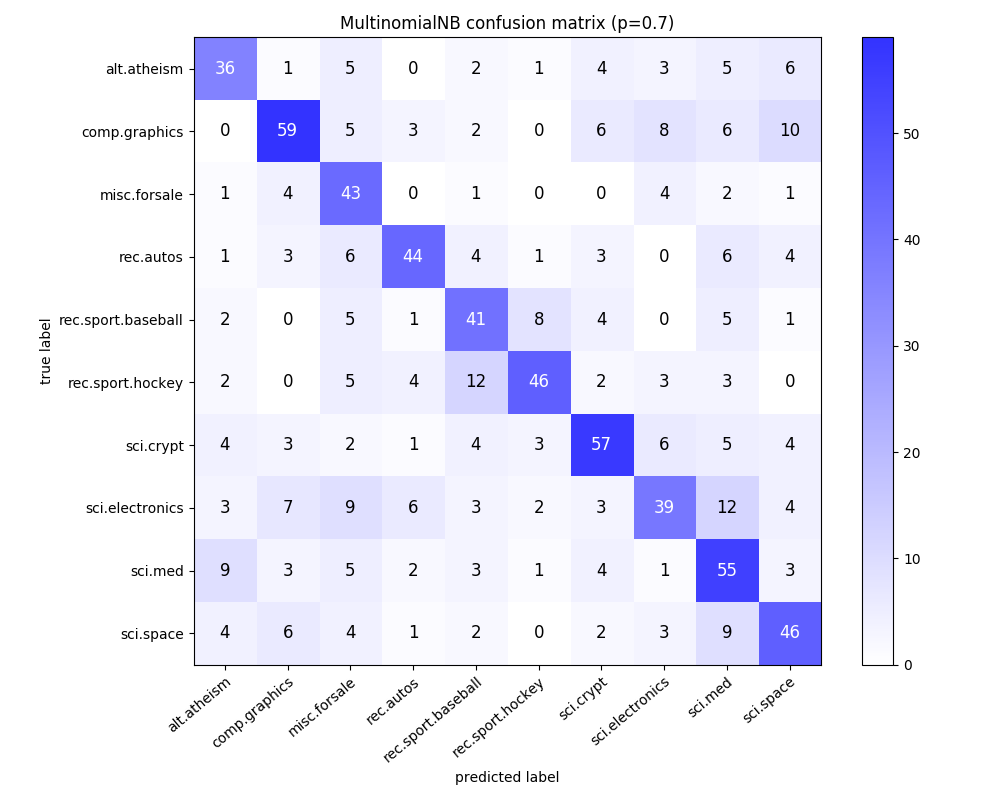

<IPython.core.display.Javascript object>


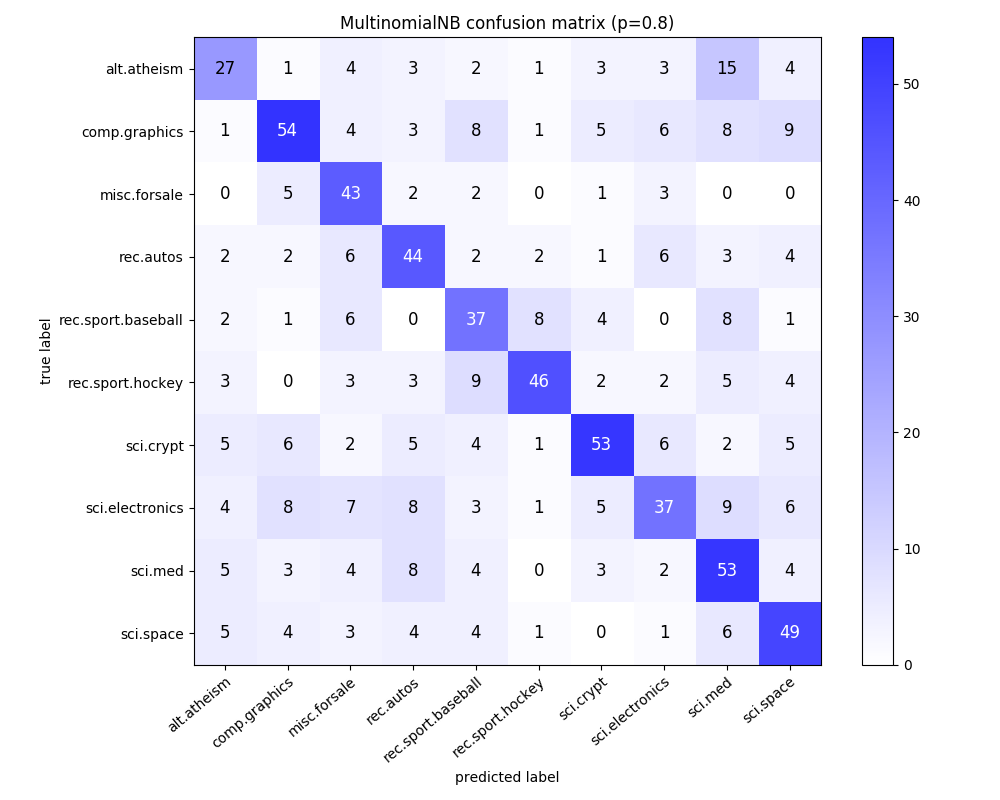

<IPython.core.display.Javascript object>


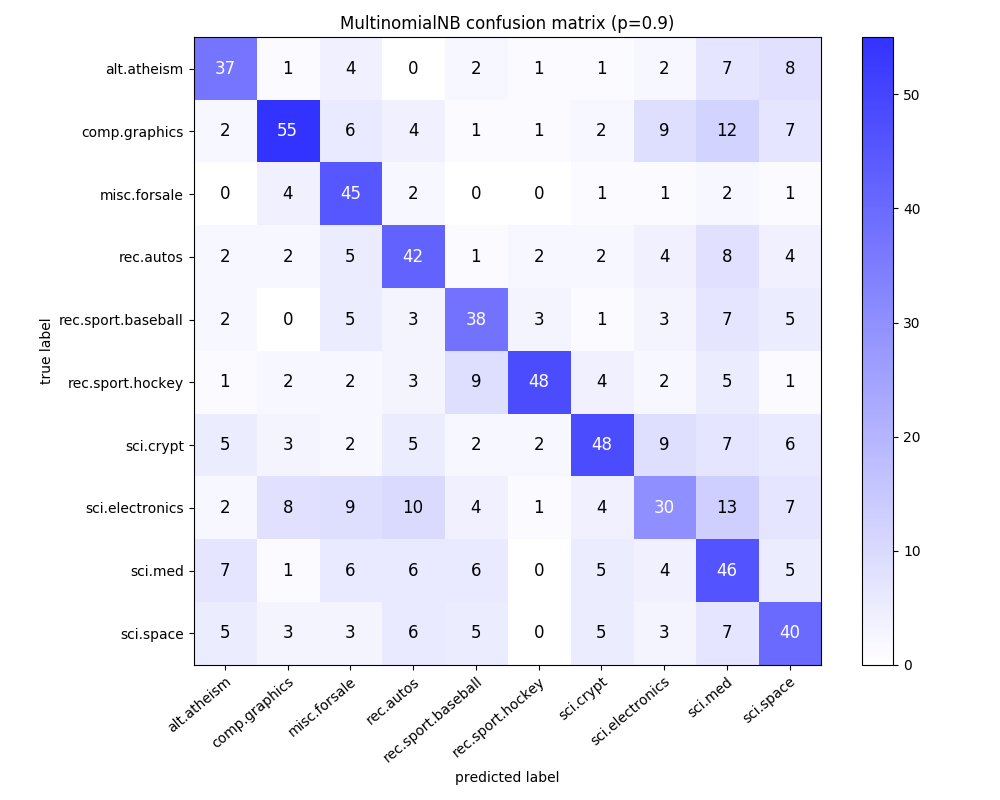

<IPython.core.display.Javascript object>


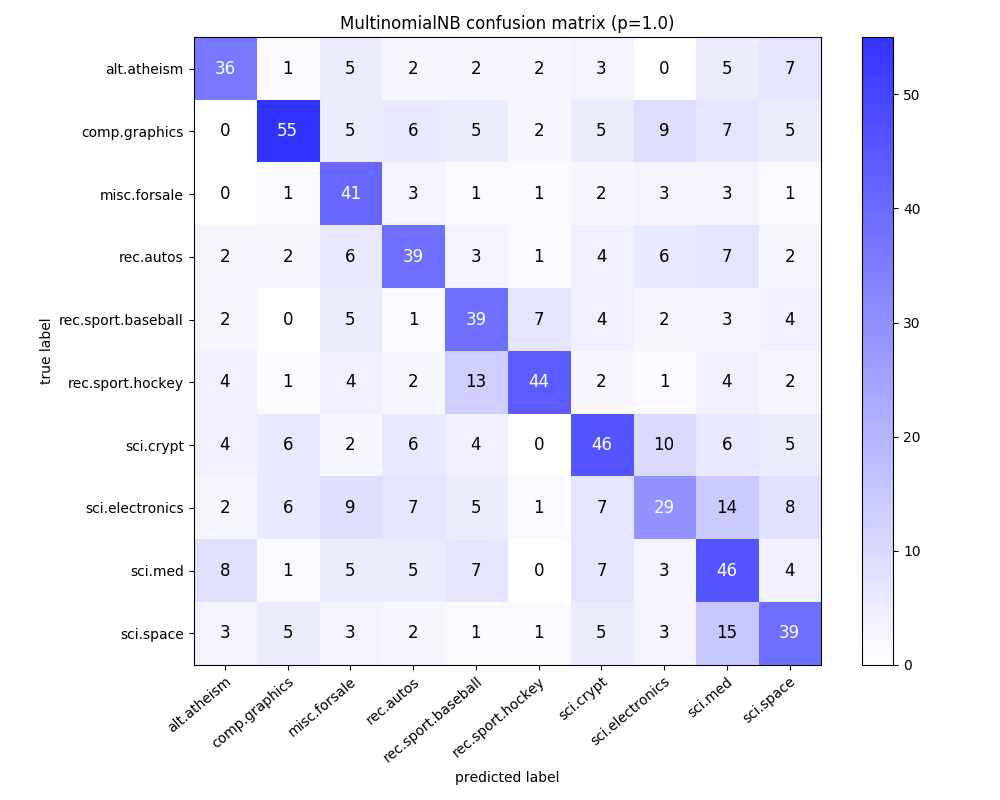

<IPython.core.display.Javascript object>


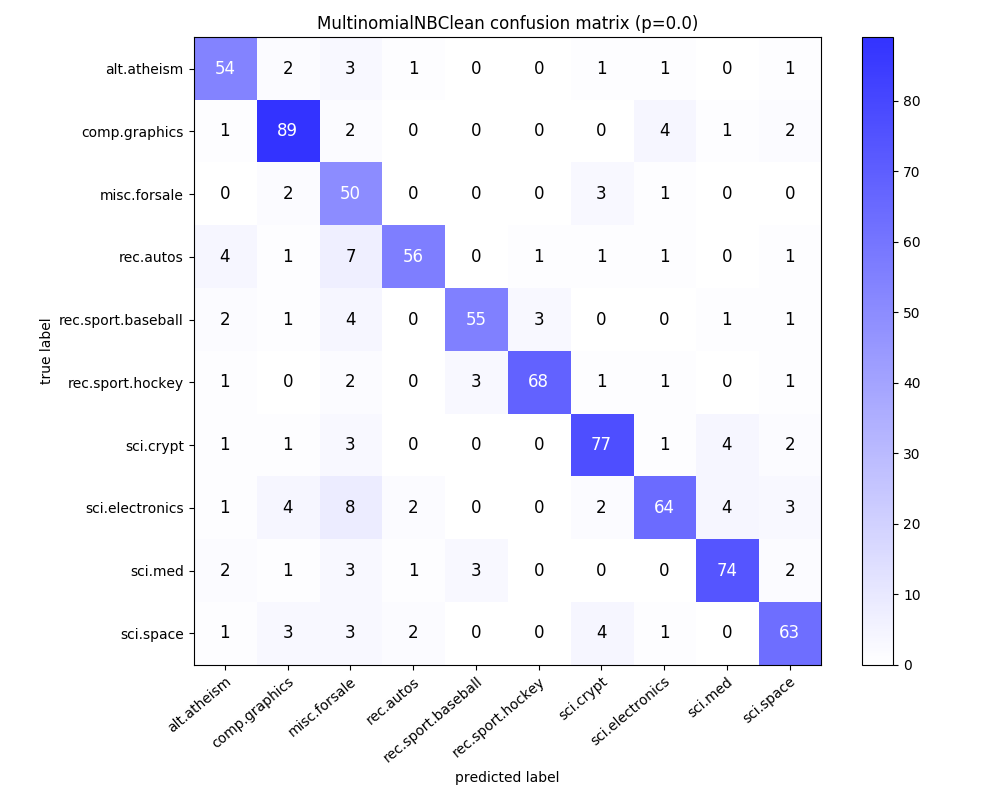

<IPython.core.display.Javascript object>


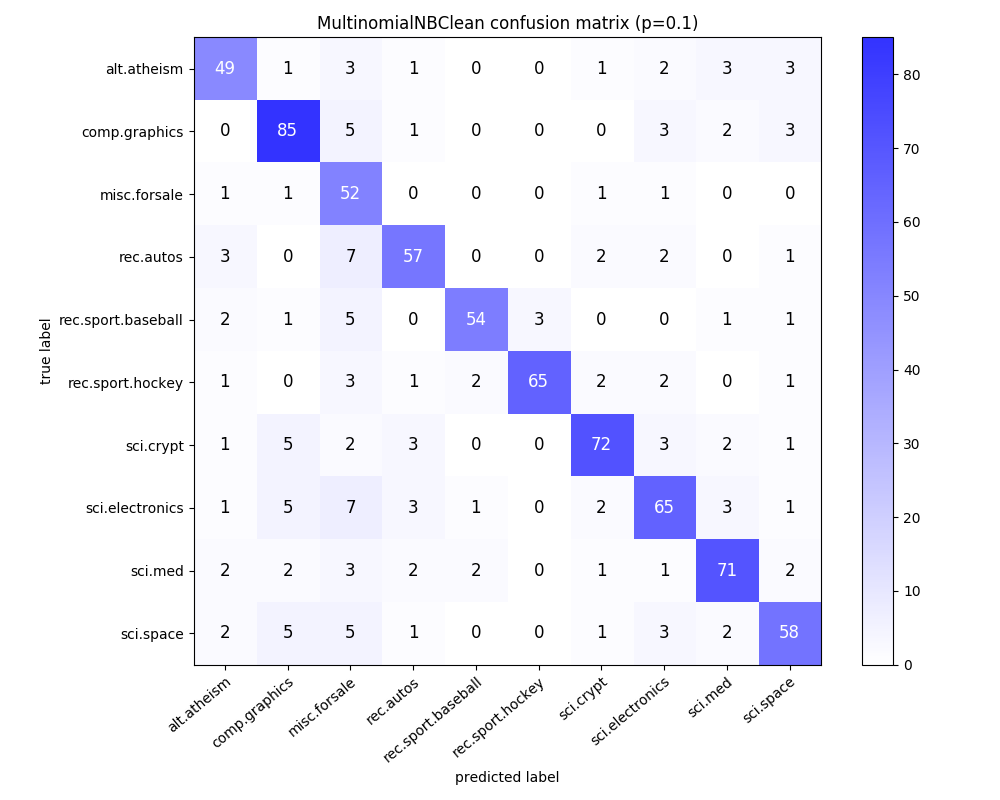

<IPython.core.display.Javascript object>


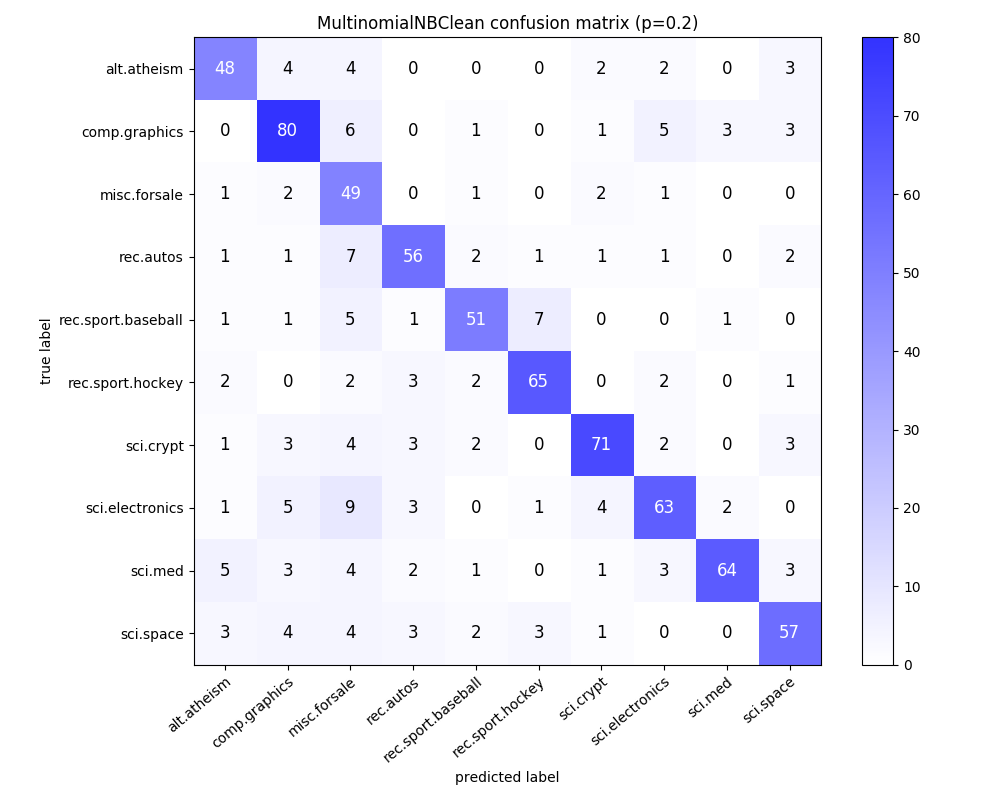

<IPython.core.display.Javascript object>


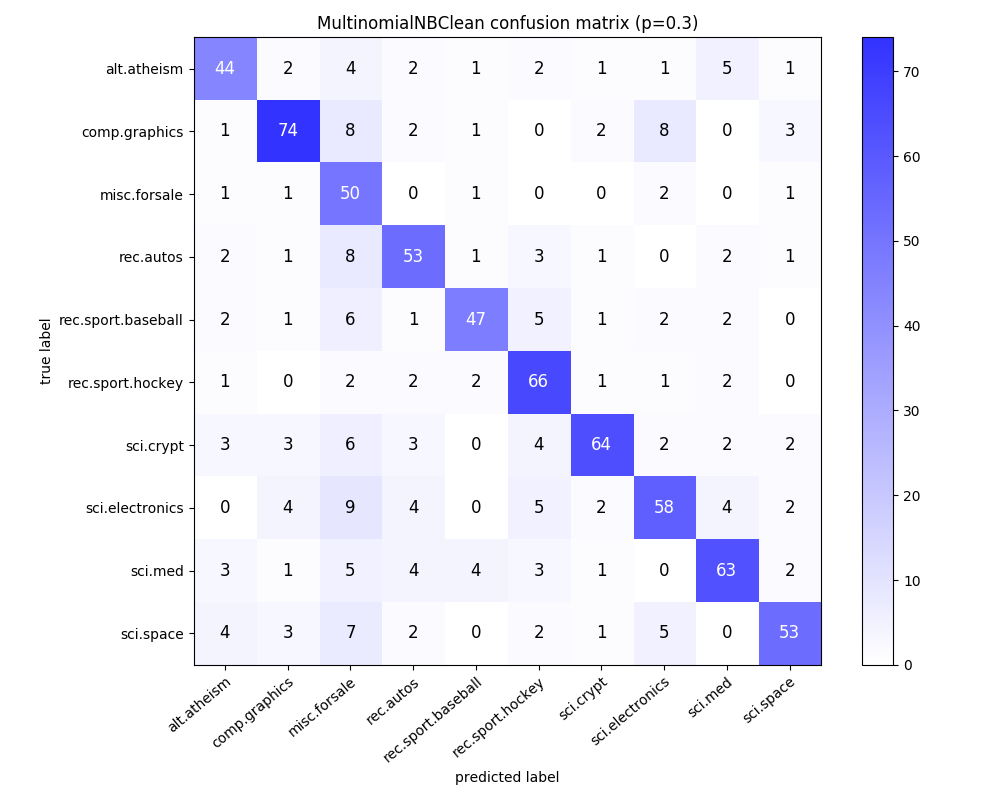

<IPython.core.display.Javascript object>


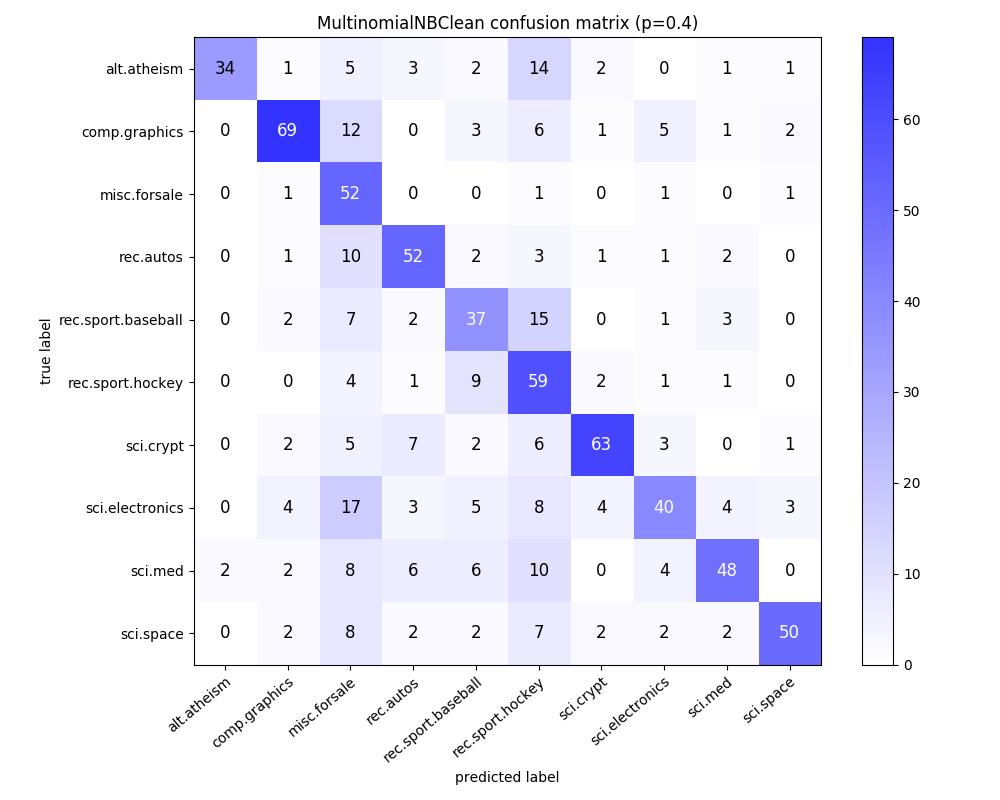

<IPython.core.display.Javascript object>


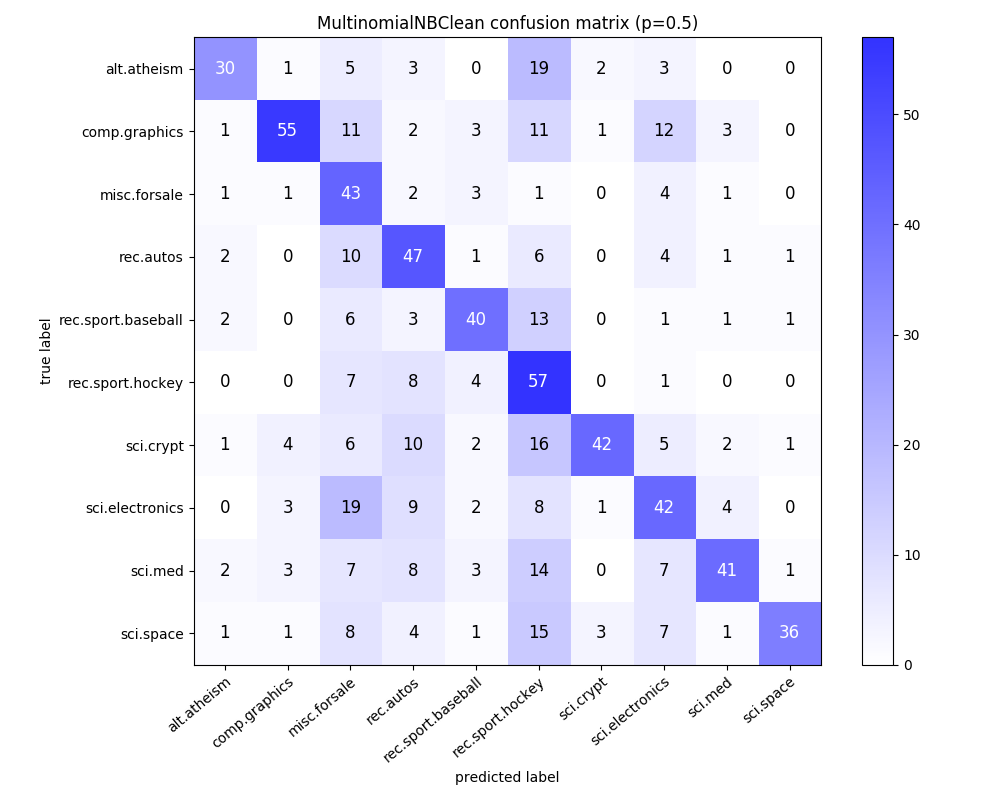

<IPython.core.display.Javascript object>


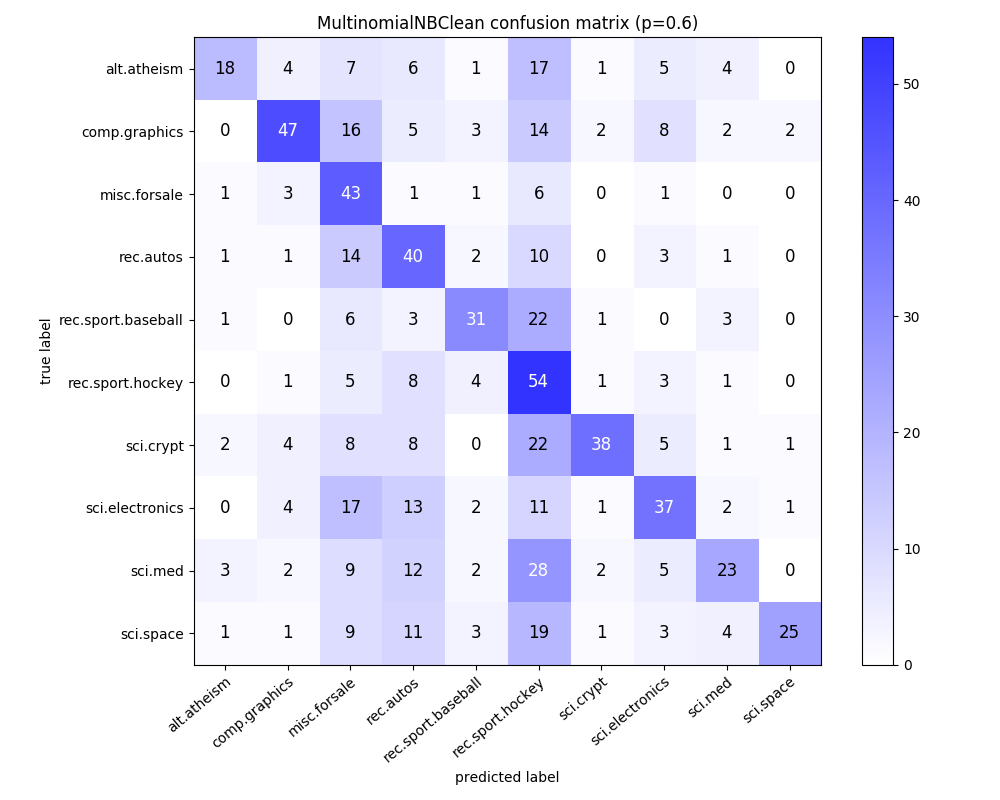

<IPython.core.display.Javascript object>


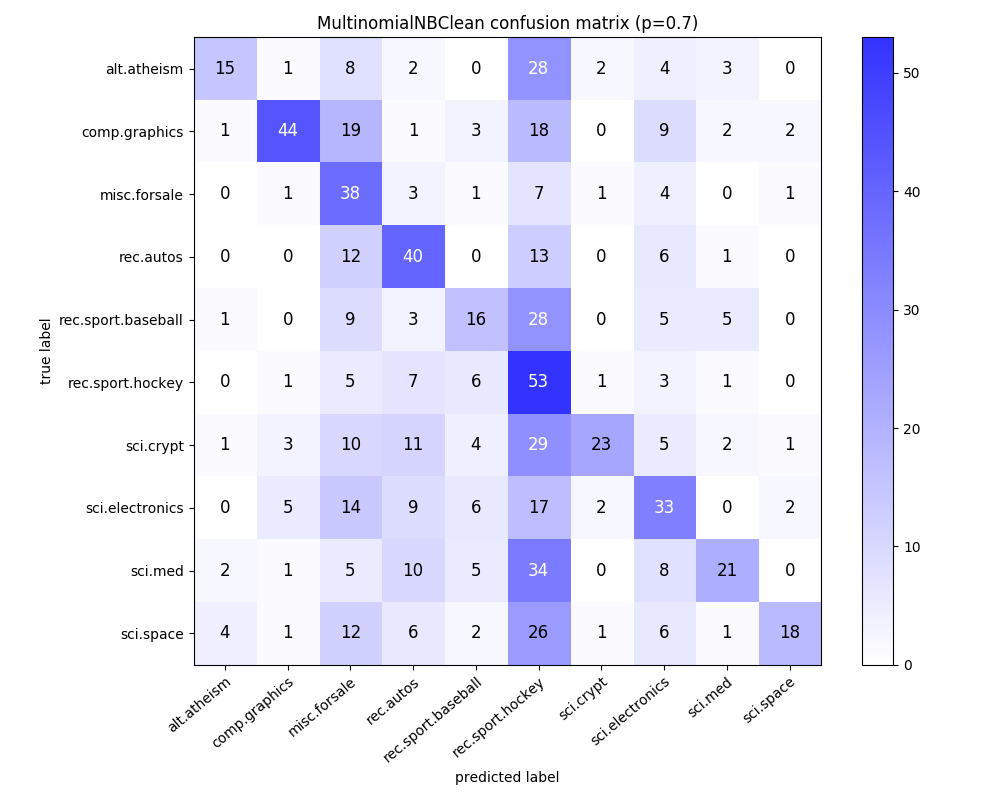

<IPython.core.display.Javascript object>


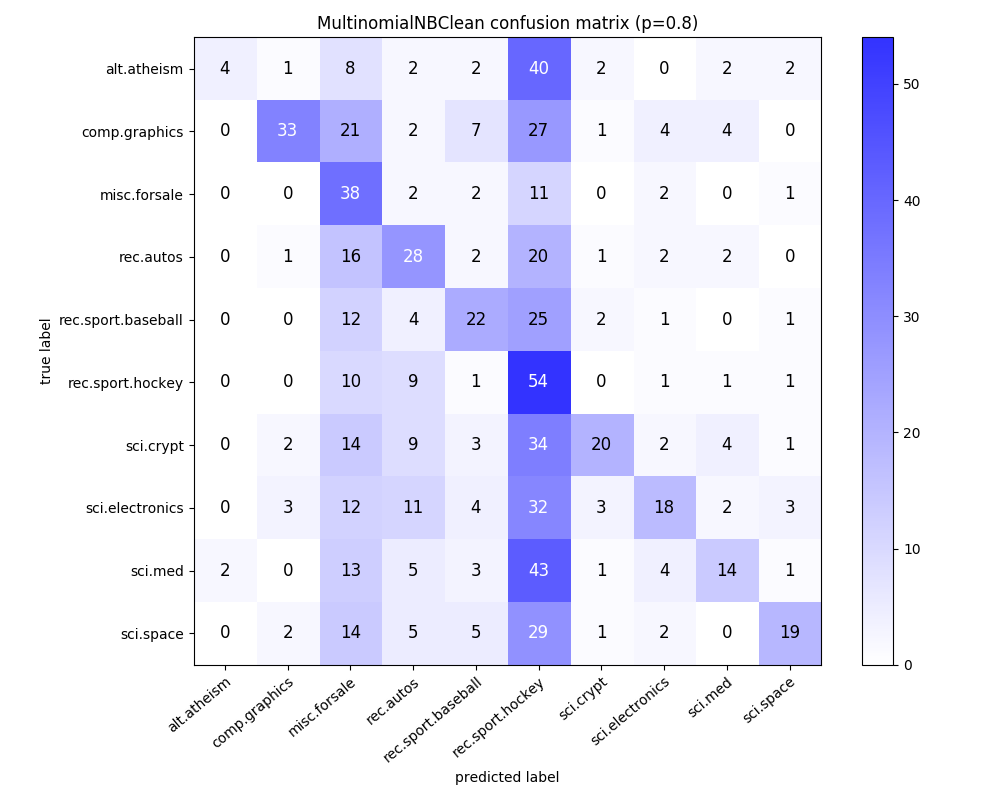

<IPython.core.display.Javascript object>


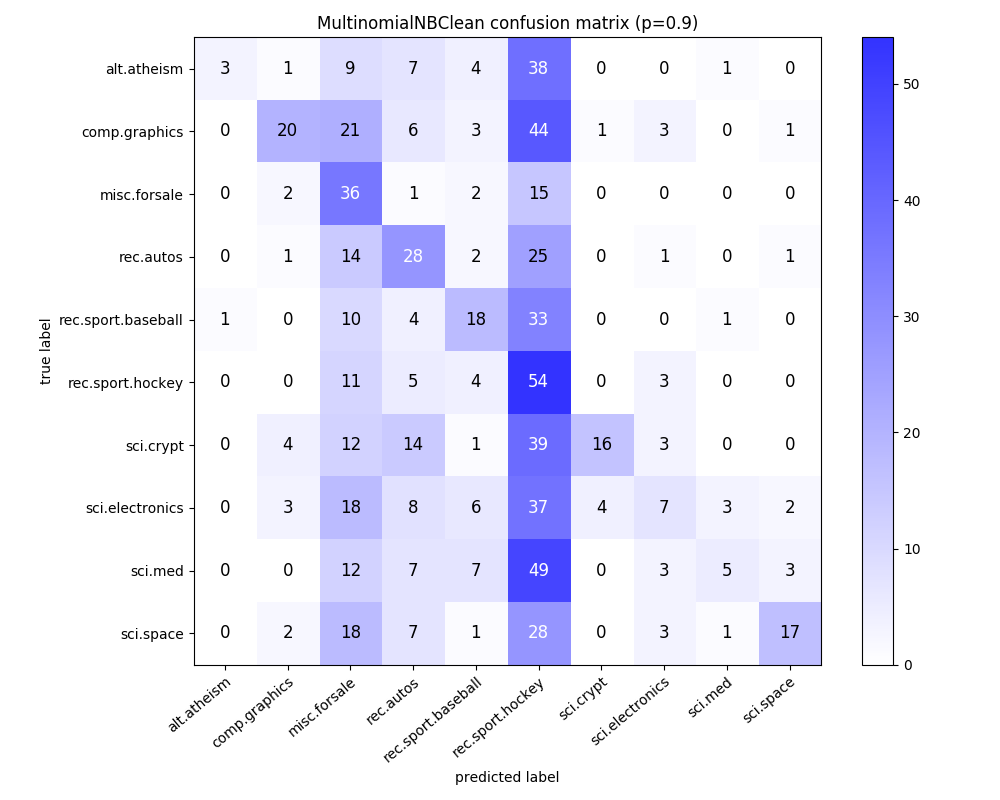

<IPython.core.display.Javascript object>


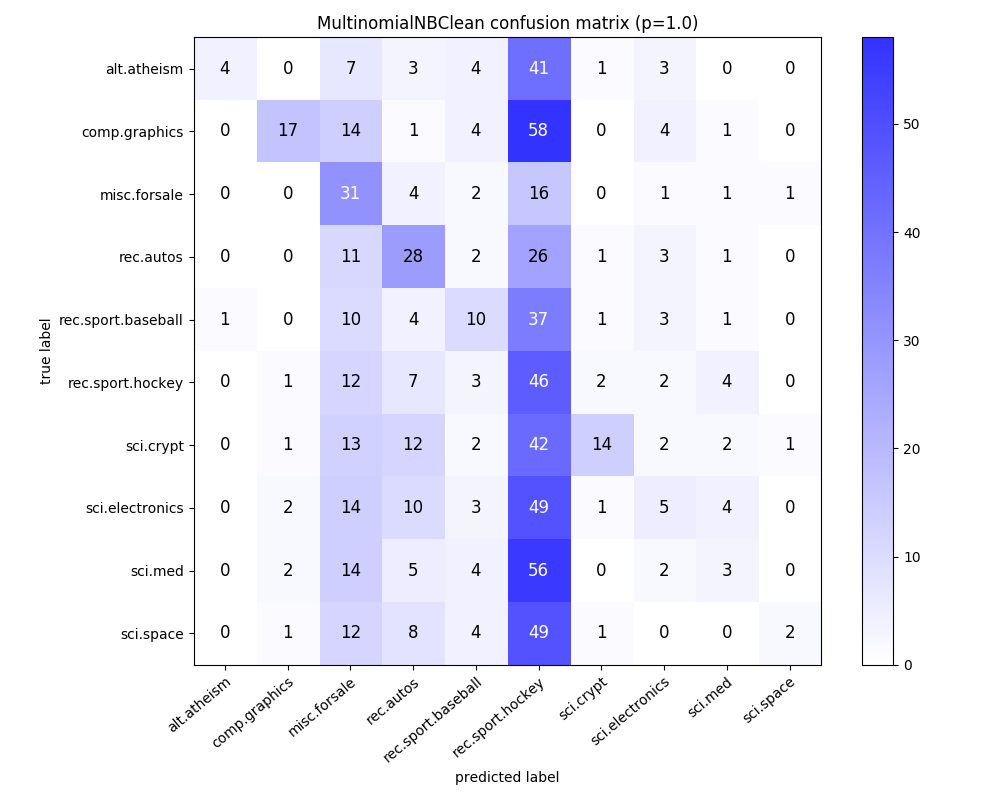

In [6]:
main(["x", "test", "10"])